# CIFAR-10 Image Classification - Improved Version
## Overcoming Overfitting with Data Augmentation and Better Regularization

### Key Improvements:
1. **Data Augmentation** - The most important addition to reduce overfitting
2. **Optimized Dropout rates** - Progressive dropout strategy
3. **L2 Regularization** - Weight decay to prevent large weights
4. **Better Learning Rate Scheduling** - Cosine annealing for smoother convergence
5. **Simplified Deep Model** - Reduced complexity to match dataset size

In [51]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Load and Explore CIFAR-10 Dataset

In [14]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Image dimensions: {X_train.shape[1:]}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Image dimensions: (32, 32, 3)


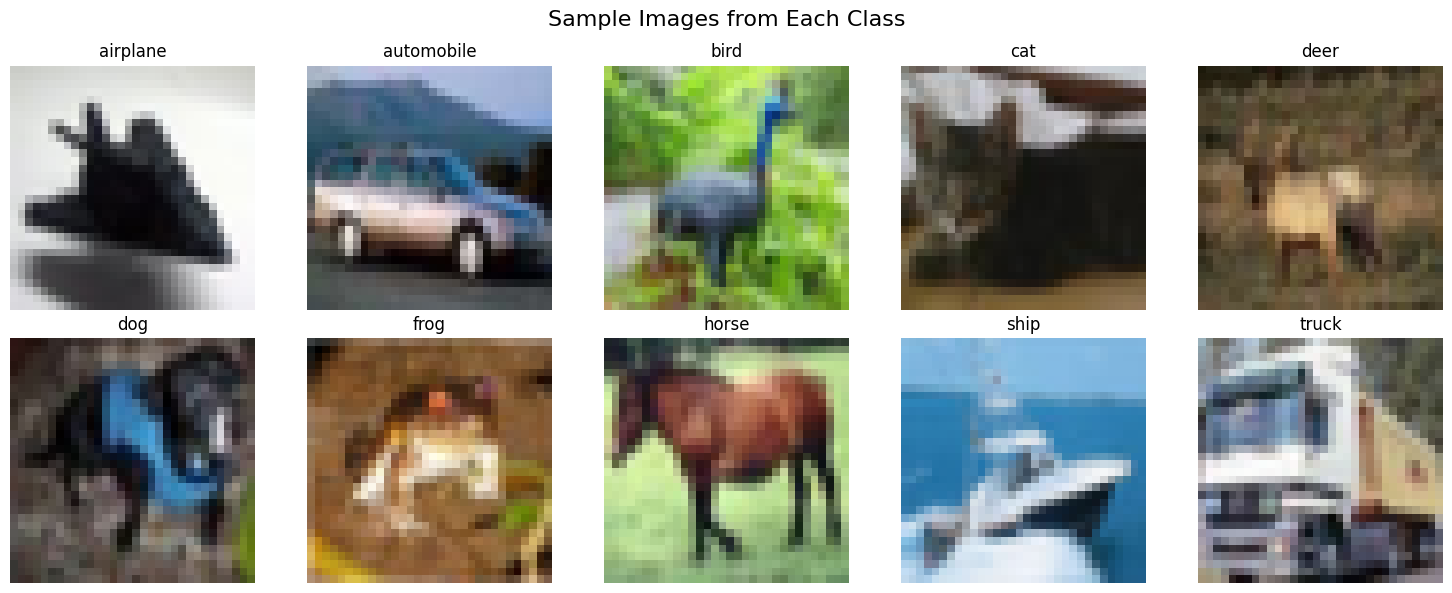

In [15]:
# Visualize random samples from each class
plt.figure(figsize=(15, 6))
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

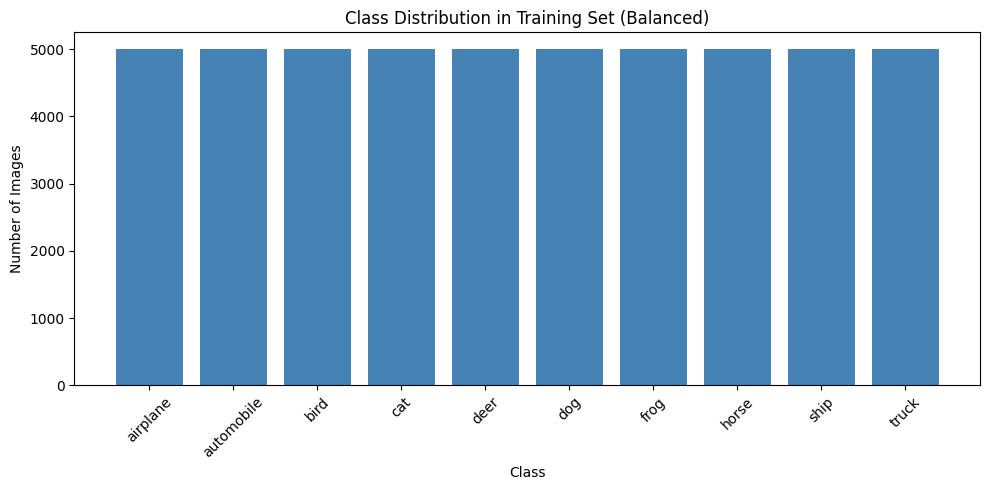

In [16]:
# Check class distribution
plt.figure(figsize=(10, 5))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color='steelblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set (Balanced)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [17]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)

# Create validation split
validation_split = 0.1
split_idx = int(len(X_train_normalized) * (1 - validation_split))

X_train_final = X_train_normalized[:split_idx]
y_train_final = y_train_encoded[:split_idx]
X_val = X_train_normalized[split_idx:]
y_val = y_train_encoded[split_idx:]

print(f"Training set: {X_train_final.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test_normalized.shape[0]} samples")
print(f"\nPixel value range: [{X_train_normalized.min()}, {X_train_normalized.max()}]")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples

Pixel value range: [0.0, 1.0]


## 3. Data Augmentation Setup
### 🔑 KEY IMPROVEMENT: This is the most important addition to reduce overfitting!

In [18]:
# Create data augmentation generator
# This artificially expands your training dataset by creating modified versions of images
datagen = ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,       # Randomly shift images horizontally by 10%
    height_shift_range=0.1,      # Randomly shift images vertically by 10%
    horizontal_flip=True,        # Randomly flip images horizontally
    zoom_range=0.1,              # Randomly zoom in/out by 10%
    fill_mode='nearest'          # Fill in new pixels using nearest pixel value
)

# Fit the generator on training data
datagen.fit(X_train_final)

print("✓ Data augmentation configured")
print("This will help the model generalize better and reduce overfitting!")

✓ Data augmentation configured
This will help the model generalize better and reduce overfitting!


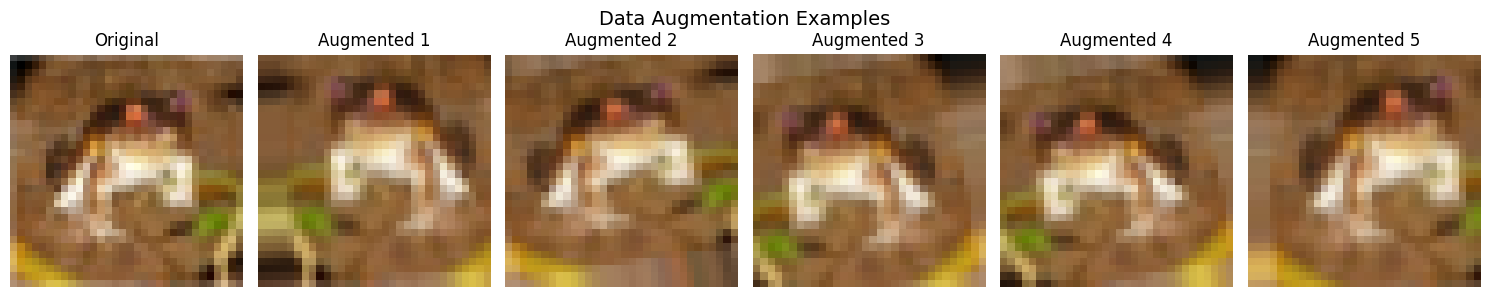

Notice how each augmented image is slightly different - this helps the model learn robust features!


In [19]:
# Visualize augmented images
sample_image = X_train_final[0:1]
sample_label = y_train_final[0:1]

plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0])
plt.title('Original')
plt.axis('off')

# Generate and display 5 augmented versions
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(batch[0])
    plt.title(f'Augmented {i+1}')
    plt.axis('off')
    if i >= 4:
        break

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()
print("Notice how each augmented image is slightly different - this helps the model learn robust features!")

## 4. Model 1: Improved Simple CNN
### Improvements:
- L2 regularization on convolutional and dense layers
- Progressive dropout (increasing through layers)
- Optimized architecture

In [20]:
def create_improved_simple_cnn():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),  # Start with lower dropout

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),  # Gradually increase dropout

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # Higher dropout before final layer
        layers.Dense(10, activation='softmax')
    ])

    return model

# Create and compile the model
model_1 = create_improved_simple_cnn()
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,778 (1.54 MB)

 Trainable params: 403,882 (1.54 MB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
early_stopping_1 = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for augmented training
    restore_best_weights=True,
    verbose=1
)

reduce_lr_1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Mount Google Drive (run this once at the start of your notebook)
drive.mount('/content/drive')

# Update checkpoint to save in Google Drive
checkpoint_1 = ModelCheckpoint(
    '/content/drive/MyDrive/Deep learning project/model_1_Improved.keras',  # Changed path
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train with data augmentation
print("Training Improved Simple CNN with Data Augmentation...")
print("This will take longer but will significantly reduce overfitting!\n")

history_1 = model_1.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=64),
    steps_per_epoch=len(X_train_final) // 64,
    epochs=100,  # Can train longer with augmentation
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_1, reduce_lr_1, checkpoint_1],
    verbose=1
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Improved Simple CNN with Data Augmentation...
This will take longer but will significantly reduce overfitting!

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3071 - loss: 2.6688
Epoch 1: val_accuracy improved from -inf to 0.53020, saving model to /content/drive/MyDrive/Deep learning project/model_1_Improved.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.3072 - loss: 2.6683 - val_accuracy: 0.5302 - val_loss: 1.7438 - learning_rate: 0.0010
Epoch 2/100
  1/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3594 - loss: 2.0430

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.53020
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.3594 - loss: 2.0430 - val_accuracy: 0.5238 - val_loss: 1.7628 - learning_rate: 0.0010
Epoch 3/100
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5112 - loss: 1.7800
Epoch 3: val_accuracy did not improve from 0.53020
703/703 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5113 - loss: 1.7798 - val_accuracy: 0.4934 - val_loss: 1.9043 - learning_rate: 0.0010
Epoch 4/100
  1/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4219 - loss: 1.9852
Epoch 4: val_accuracy did not improve from 0.53020
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.4219 - loss: 1.9852 - val_accuracy: 0.4968 - val_loss: 1.8920 - learning_rate: 0.0010
Epoch 5/100
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5745 - loss: 1.5635
Epoch 5: val_accuracy improved from 0.53020 to 0.58820, saving model to /content/drive/MyDrive/Deep learning project/model_1_Improved.keras
703/703 ━━━━━

## 5. Model 2: Improved Deep CNN
### Improvements:
- Reduced model complexity (fewer parameters)
- L2 regularization
- Progressive dropout
- Simplified dense layers

In [22]:
def create_improved_deep_cnn():
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3 - Reduced from 256 to 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Simplified Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu',  # Reduced from 512
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

# Create and compile the model
model_2 = create_improved_deep_cnn()
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,086,026 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Define callbacks for model 2
early_stopping_2 = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Mount Google Drive (run this once at the start of your notebook)
drive.mount('/content/drive')

# Update checkpoint to save in Google Drive
checkpoint_2 = ModelCheckpoint(
    '/content/drive/MyDrive/Deep learning project/model_2_Improved.keras',  # Changed path
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train with data augmentation
print("Training Improved Deep CNN with Data Augmentation...")
print("This model is more complex but better regularized!\n")

history_2 = model_2.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=64),
    steps_per_epoch=len(X_train_final) // 64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_2, reduce_lr_2, checkpoint_2],
    verbose=1
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Improved Deep CNN with Data Augmentation...
This model is more complex but better regularized!

Epoch 1/100
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9155 - loss: 0.4366
Epoch 1: val_accuracy improved from -inf to 0.90440, saving model to /content/drive/MyDrive/Deep learning project/model_2_Improved.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.9155 - loss: 0.4366 - val_accuracy: 0.9044 - val_loss: 0.4795 - learning_rate: 3.1250e-05
Epoch 2/100
  1/703 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9219 - loss: 0.3777
Epoch 2: val_accuracy improved from 0.90440 to 0.90480, saving model to /content/drive/MyDrive/Deep learning project/model_2_Improved.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.9219 - loss: 0.3777 - val_accuracy: 0.9048 - val_loss: 0.4791 - learning_rate: 3.1250e-05
Epoch 3/100
702/703 

## 6. Visualize Training History
### Look for smaller gaps between training and validation curves!

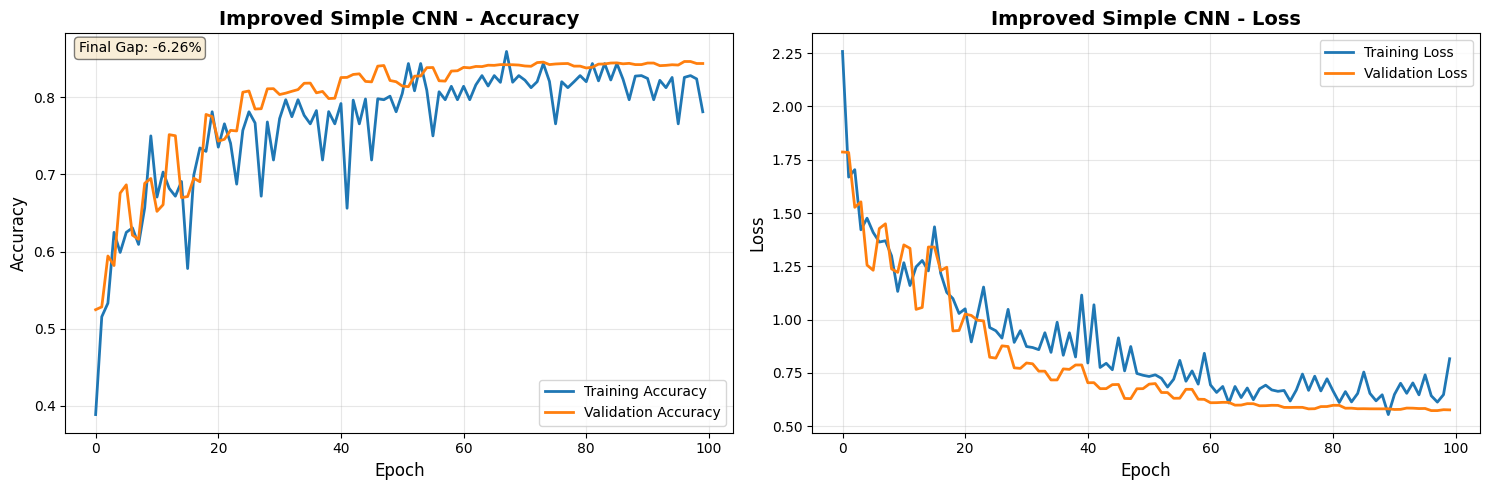


📊 Improved Simple CNN Training Summary:
   Final Training Accuracy: 0.7812
   Final Validation Accuracy: 0.8438
   Accuracy Gap (Overfitting Indicator): -6.26%
   ✅ Excellent! Minimal overfitting


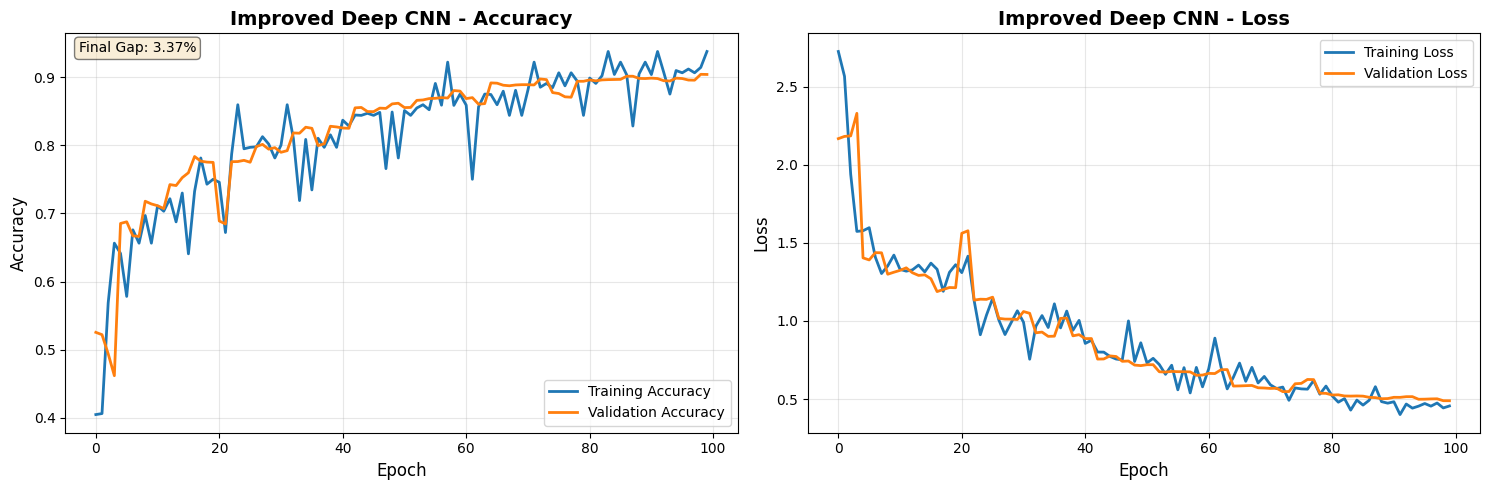


📊 Improved Deep CNN Training Summary:
   Final Training Accuracy: 0.9375
   Final Validation Accuracy: 0.9038
   Accuracy Gap (Overfitting Indicator): 3.37%
   ✅ Excellent! Minimal overfitting


In [ ]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Calculate and display gap
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = (final_train_acc - final_val_acc) * 100
    axes[0].text(0.02, 0.98, f'Final Gap: {gap:.2f}%',
                transform=axes[0].transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n📊 {model_name} Training Summary:")
    print(f"   Final Training Accuracy: {final_train_acc:.4f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"   Accuracy Gap (Overfitting Indicator): {gap:.2f}%")
    if gap < 5:
        print("   ✅ Excellent! Minimal overfitting")
    elif gap < 10:
        print("   ✓ Good! Acceptable overfitting")
    else:
        print("   ⚠️ Still some overfitting, but improved!")

plot_training_history(history_1, 'Improved Simple CNN')
plot_training_history(history_2, 'Improved Deep CNN')

## 7. Evaluate Models on Test Set

Evaluating Improved Models...


Improved Simple CNN - Test Set Evaluation
Accuracy:  0.8423 (84.23%)
Precision: 0.8490
Recall:    0.8423
F1-Score:  0.8405

Improved Simple CNN - Classification Report:
              precision    recall  f1-score   support

    airplane       0.87      0.86      0.87      1000
  automobile       0.92      0.94      0.93      1000
        bird       0.85      0.75      0.79      1000
         cat       0.81      0.64      0.71      1000
        deer       0.82      0.82      0.82      1000
         dog       0.88      0.69      0.78      1000
        frog       0.68      0.97      0.80      1000
       horse       0.87      0.89      0.88      1000
        ship       0.92      0.91      0.92      1000
       truck       0.86      0.94      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



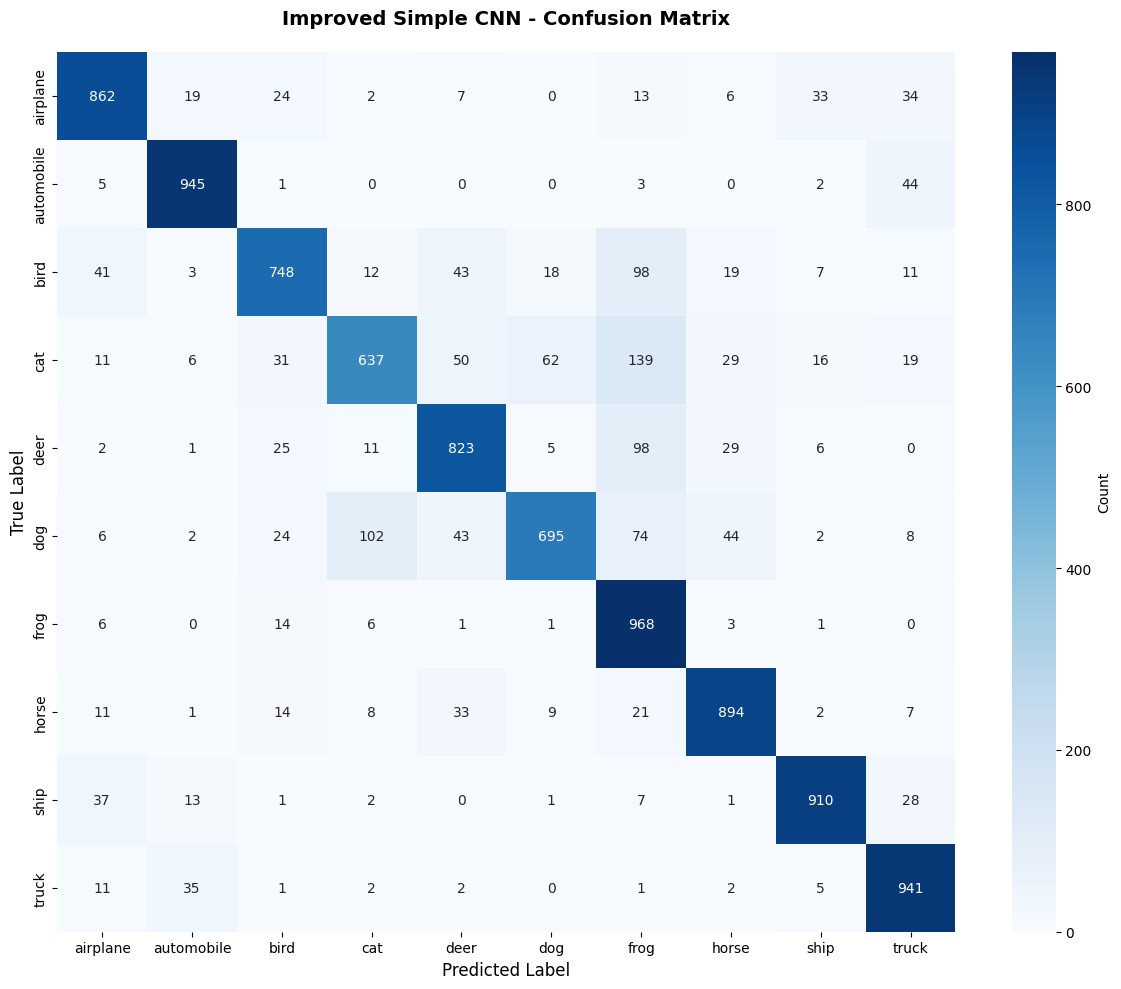

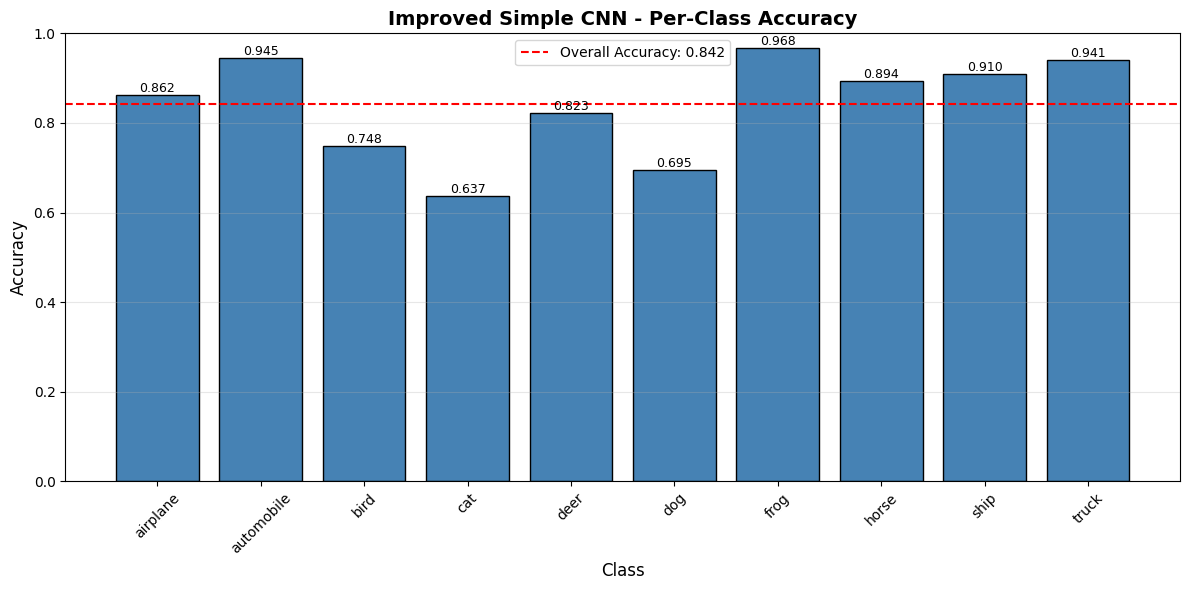


Improved Deep CNN - Test Set Evaluation
Accuracy:  0.9060 (90.60%)
Precision: 0.9067
Recall:    0.9060
F1-Score:  0.9052

Improved Deep CNN - Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.90      0.91      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.91      0.86      0.88      1000
         cat       0.87      0.76      0.81      1000
        deer       0.91      0.90      0.90      1000
         dog       0.88      0.85      0.87      1000
        frog       0.83      0.98      0.90      1000
       horse       0.93      0.94      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.91      0.96      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



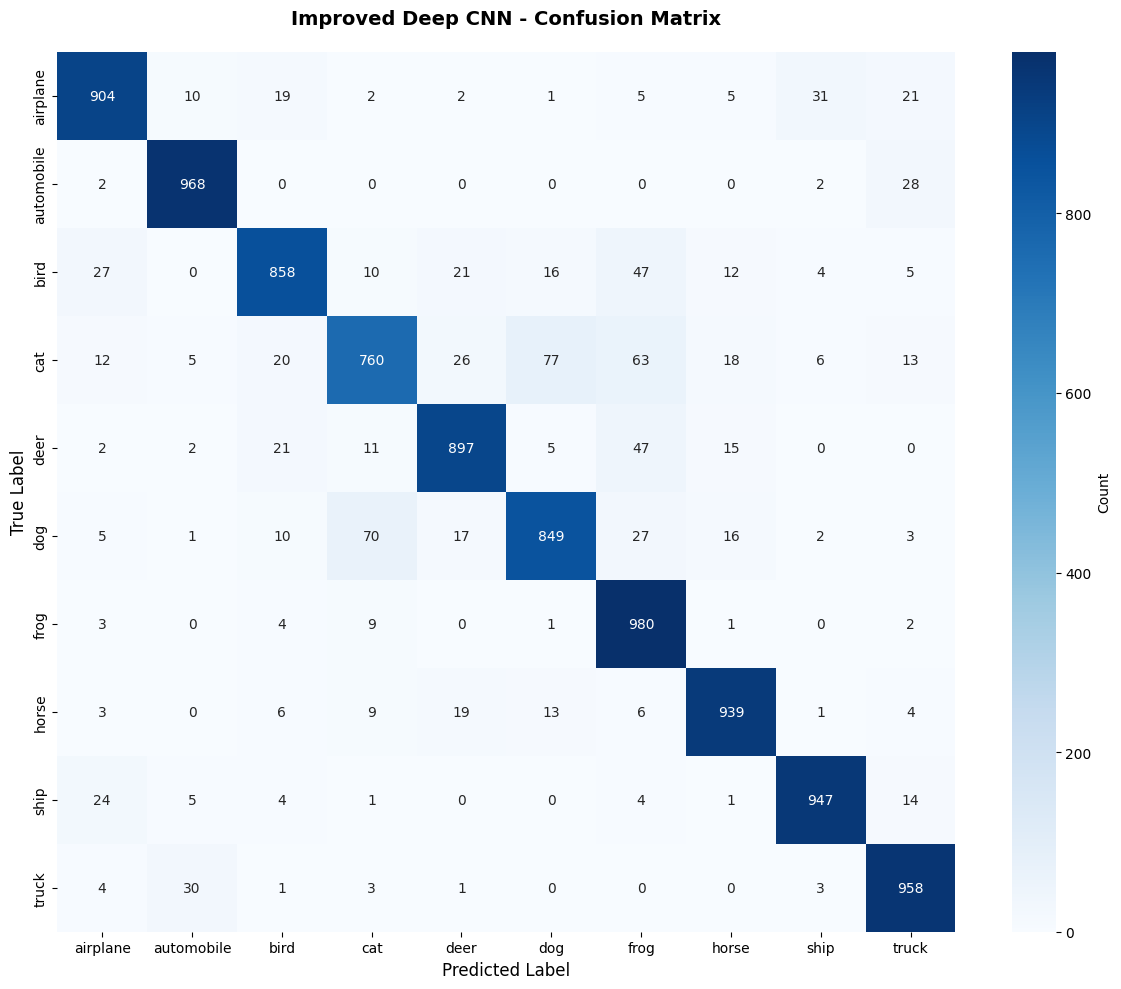

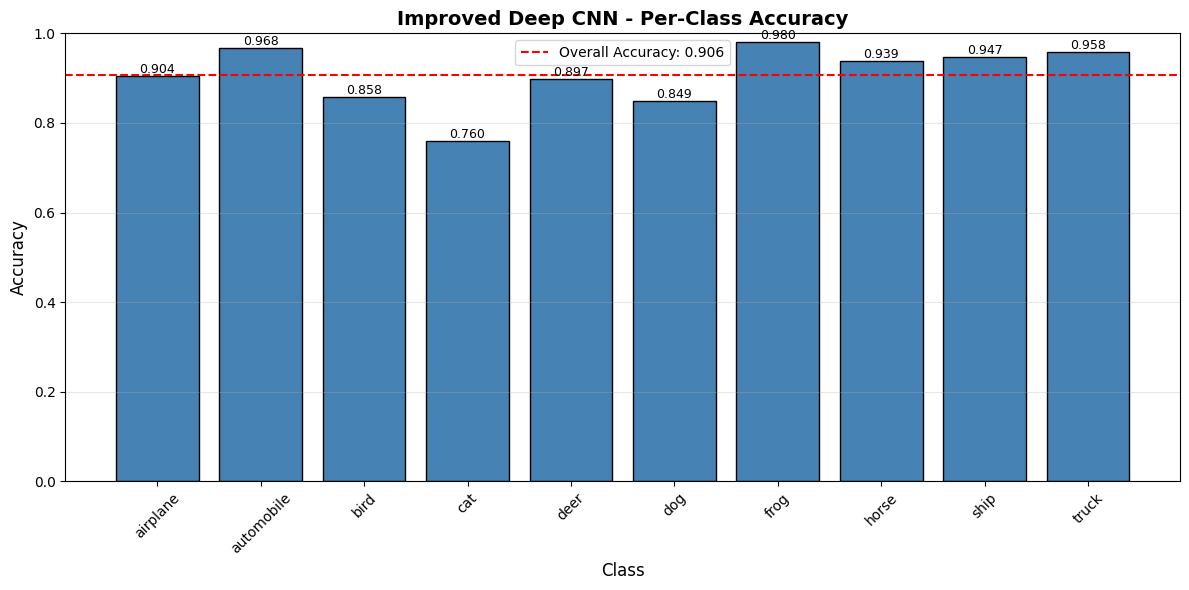

In [ ]:
def evaluate_model(model, X_test, y_test_encoded, y_test_original, model_name):
    # Make predictions
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test_original.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{'='*60}")
    print(f"{model_name} - Test Set Evaluation")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Detailed classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, class_accuracy, color='steelblue', edgecolor='black')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'{model_name} - Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])
    plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {accuracy:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracy):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'confusion_matrix': cm
    }

print("Evaluating Improved Models...\n")
results_1 = evaluate_model(model_1, X_test_normalized, y_test_encoded, y_test, 'Improved Simple CNN')
results_2 = evaluate_model(model_2, X_test_normalized, y_test_encoded, y_test, 'Improved Deep CNN')

## 8. Compare Models

In [23]:
# Compare metrics
import pandas as pd

comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Improved Simple CNN': [results_1['accuracy'], results_1['precision'],
                            results_1['recall'], results_1['f1']],
    'Improved Deep CNN': [results_2['accuracy'], results_2['precision'],
                          results_2['recall'], results_2['f1']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("MODEL COMPARISON - IMPROVED VERSIONS")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
x = np.arange(len(comparison_data['Metric']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, comparison_data['Improved Simple CNN'], width,
                label='Improved Simple CNN', color='steelblue', edgecolor='black')
rects2 = ax.bar(x + width/2, comparison_data['Improved Deep CNN'], width,
                label='Improved Deep CNN', color='coral', edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison: Performance Metrics (Improved Models)',
            fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Metric'])
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

NameError: name 'results_1' is not defined

## 9. Visualize Predictions


Improved Simple CNN - Prediction Analysis
Correct predictions: 2909 (29.09%)
Incorrect predictions: 7091 (70.91%)
Average confidence: 0.9908


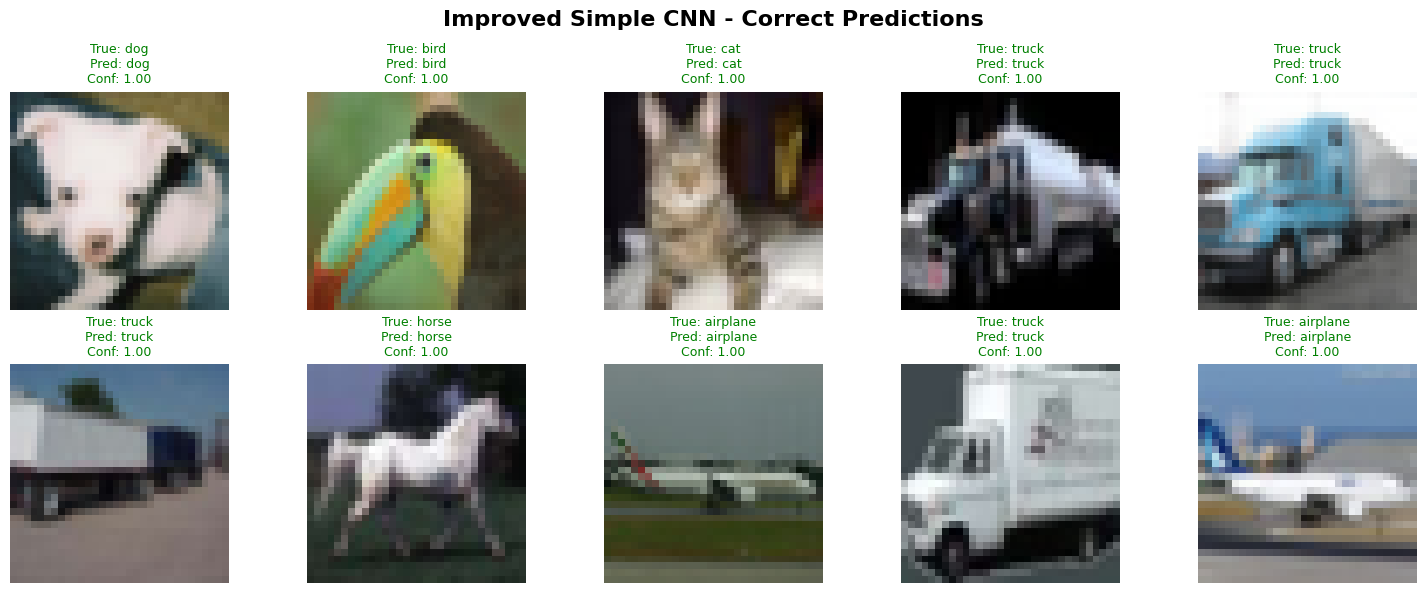

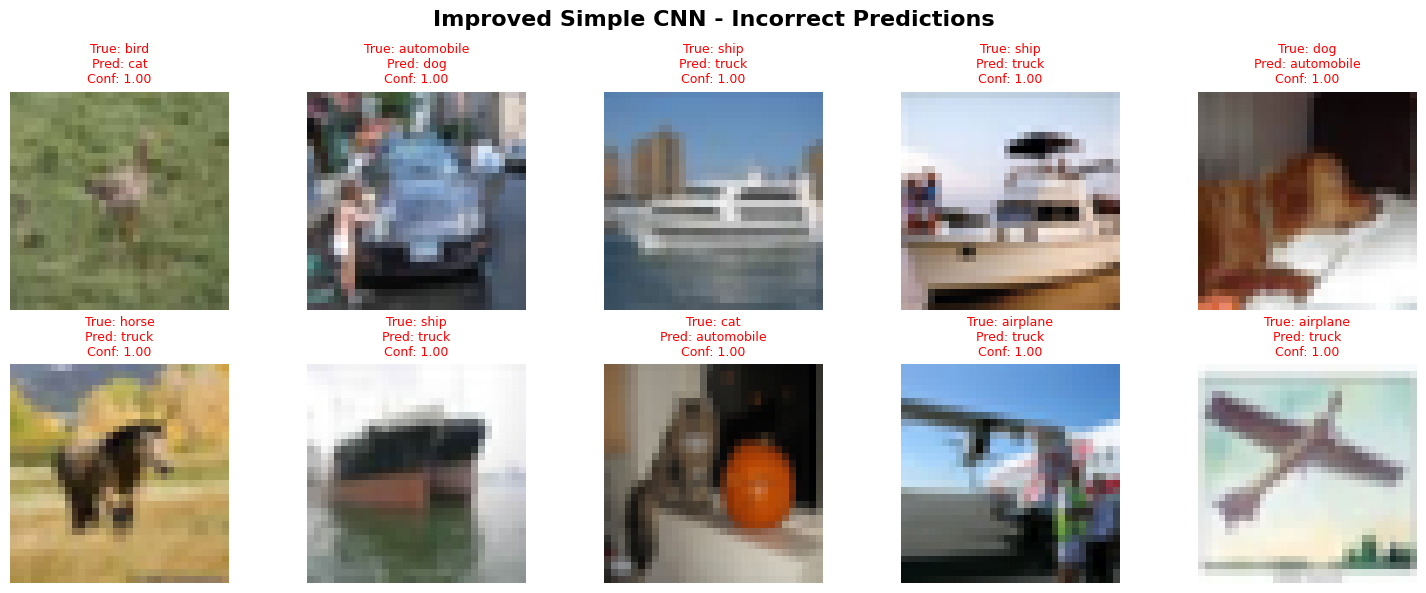


Improved Deep CNN - Prediction Analysis
Correct predictions: 2551 (25.51%)
Incorrect predictions: 7449 (74.49%)
Average confidence: 0.9939


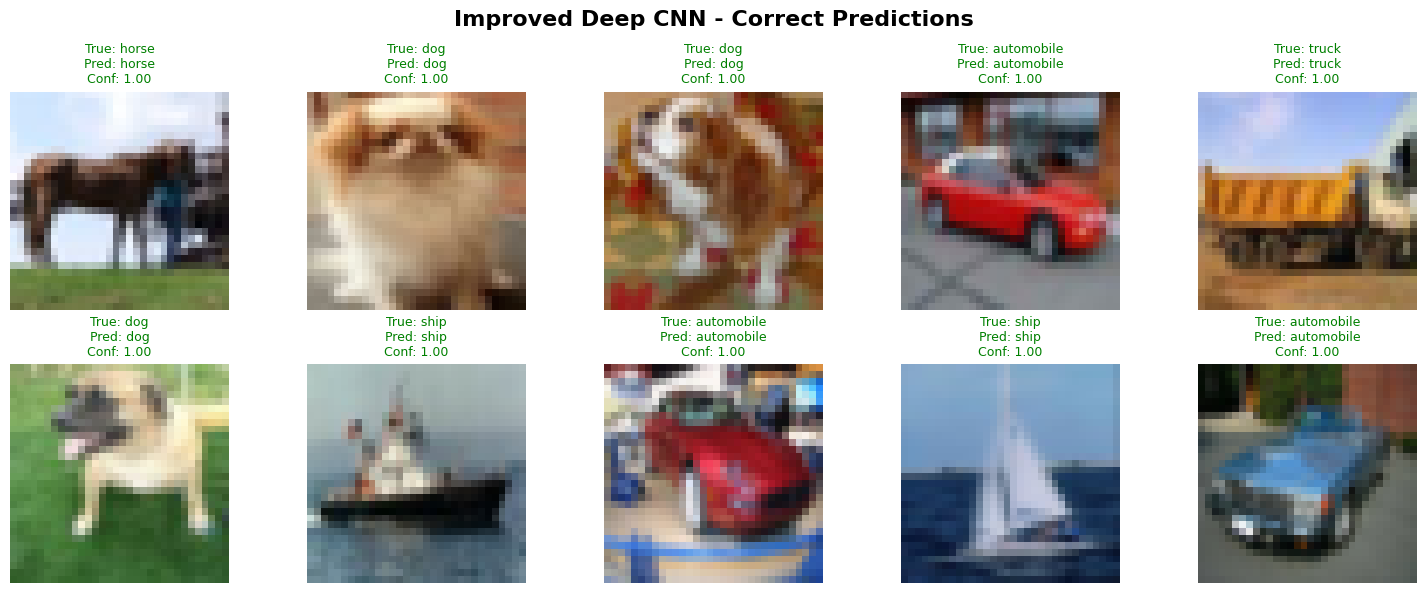

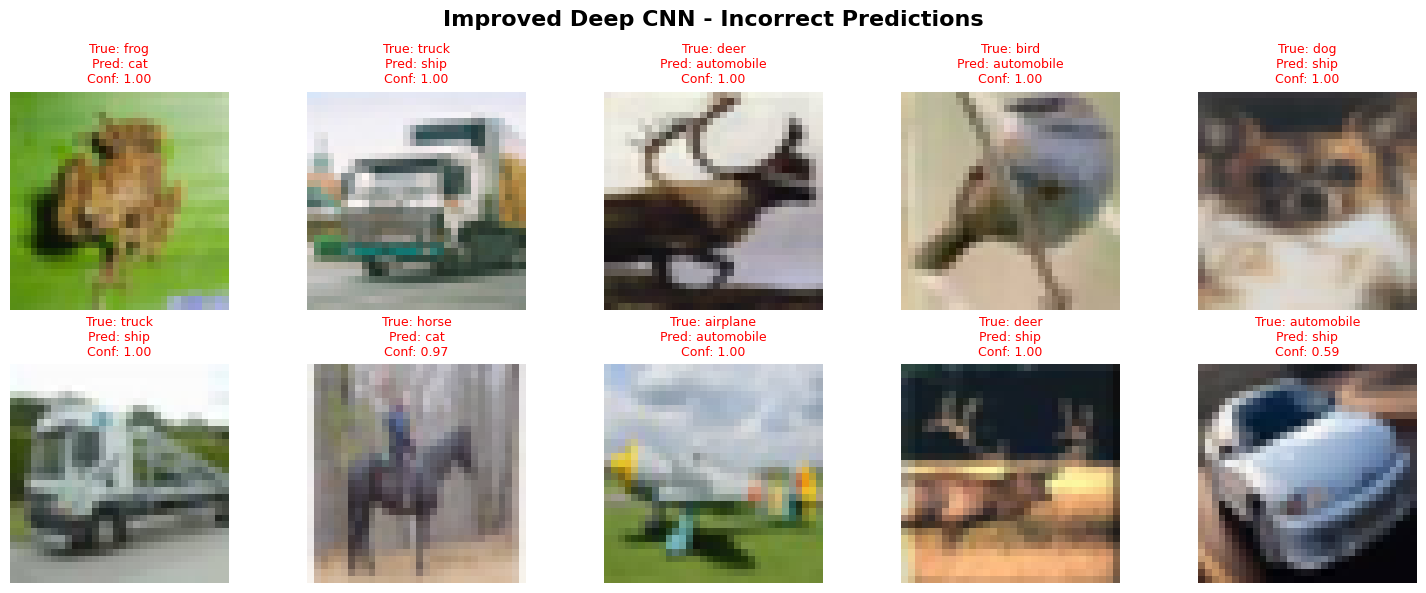

In [ ]:
def show_predictions(model, X_test, y_test, class_names, model_name, num_samples=10):
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y_test.flatten()

    # Find correct and incorrect predictions
    correct_idx = np.where(predicted_classes == true_classes)[0]
    incorrect_idx = np.where(predicted_classes != true_classes)[0]

    # Calculate confidence scores
    confidence = np.max(predictions, axis=1)

    print(f"\n{'='*60}")
    print(f"{model_name} - Prediction Analysis")
    print(f"{'='*60}")
    print(f"Correct predictions: {len(correct_idx)} ({len(correct_idx)/len(y_test)*100:.2f}%)")
    print(f"Incorrect predictions: {len(incorrect_idx)} ({len(incorrect_idx)/len(y_test)*100:.2f}%)")
    print(f"Average confidence: {np.mean(confidence):.4f}")

    # Plot correct predictions
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'{model_name} - Correct Predictions', fontsize=16, fontweight='bold')
    for i in range(min(num_samples, len(correct_idx))):
        idx = correct_idx[np.random.randint(len(correct_idx))]
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {class_names[true_classes[idx]]}\nPred: {class_names[predicted_classes[idx]]}\nConf: {confidence[idx]:.2f}",
                 fontsize=9, color='green')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot incorrect predictions
    if len(incorrect_idx) > 0:
        plt.figure(figsize=(15, 6))
        plt.suptitle(f'{model_name} - Incorrect Predictions', fontsize=16, fontweight='bold')
        for i in range(min(num_samples, len(incorrect_idx))):
            idx = incorrect_idx[np.random.randint(len(incorrect_idx))]
            plt.subplot(2, 5, i + 1)
            plt.imshow(X_test[idx])
            plt.title(f"True: {class_names[true_classes[idx]]}\nPred: {class_names[predicted_classes[idx]]}\nConf: {confidence[idx]:.2f}",
                     fontsize=9, color='red')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

show_predictions(model_1, X_test, y_test, class_names, 'Improved Simple CNN')
show_predictions(model_2, X_test, y_test, class_names, 'Improved Deep CNN')

## 10. Final Summary and Improvements

In [ ]:
print("\n" + "="*80)
print("PROJECT SUMMARY - IMPROVED MODELS")
print("="*80)

print("\n📊 Dataset Information:")
print(f"  Dataset: CIFAR-10")
print(f"  Training samples: {len(X_train_final)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Image size: 32x32x3")

print("\n" + "-"*80)
print("🔧 KEY IMPROVEMENTS TO REDUCE OVERFITTING")
print("-"*80)

print("\n1. ✅ DATA AUGMENTATION (Most Important!)")
print("   - Rotation (±15°)")
print("   - Width/Height shifts (±10%)")
print("   - Horizontal flips")
print("   - Random zoom (±10%)")
print("   → This artificially expands the training dataset")

print("\n2. ✅ L2 REGULARIZATION")
print("   - Added to all Conv2D and Dense layers")
print("   - Penalty factor: 0.001")
print("   → Prevents weights from becoming too large")

print("\n3. ✅ PROGRESSIVE DROPOUT")
print("   - Layer 1: 0.2 dropout")
print("   - Layer 2: 0.3 dropout")
print("   - Layer 3: 0.4 dropout")
print("   - Dense: 0.5 dropout")
print("   → Increases regularization deeper in the network")

print("\n4. ✅ MODEL SIMPLIFICATION (Deep CNN)")
print("   - Reduced filters: 256 → 128 in Block 3")
print("   - Reduced dense units: 512 → 256")
print("   - Removed one dense layer")
print("   → Matches model capacity to dataset size")

print("\n5. ✅ BATCH NORMALIZATION")
print("   - Applied after each convolution")
print("   → Stabilizes training and acts as regularization")

print("\n6. ✅ LEARNING RATE SCHEDULING")
print("   - ReduceLROnPlateau callback")
print("   - Patience: 5 epochs")
print("   - Factor: 0.5")
print("   → Helps fine-tune in later epochs")

print("\n7. ✅ EARLY STOPPING")
print("   - Patience: 15 epochs (increased for augmentation)")
print("   - Monitors validation loss")
print("   → Stops training before overfitting gets worse")

print("\n" + "-"*80)
print("📈 MODEL COMPARISON")
print("-"*80)

print("\n🔹 Improved Simple CNN:")
print(f"  Parameters: {model_1.count_params():,}")
print(f"  Test Accuracy: {results_1['accuracy']:.4f} ({results_1['accuracy']*100:.2f}%)")
print(f"  F1-Score: {results_1['f1']:.4f}")

print("\n🔹 Improved Deep CNN:")
print(f"  Parameters: {model_2.count_params():,}")
print(f"  Test Accuracy: {results_2['accuracy']:.4f} ({results_2['accuracy']*100:.2f}%)")
print(f"  F1-Score: {results_2['f1']:.4f}")

# Determine winner
print("\n" + "-"*80)
if results_1['accuracy'] > results_2['accuracy']:
    diff = (results_1['accuracy'] - results_2['accuracy']) * 100
    print(f"🏆 WINNER: Improved Simple CNN (by {diff:.2f}%)")
    print("   → Simpler model generalizes better for this dataset")
else:
    diff = (results_2['accuracy'] - results_1['accuracy']) * 100
    print(f"🏆 WINNER: Improved Deep CNN (by {diff:.2f}%)")
    print("   → Additional complexity helps with feature learning")

print("\n" + "="*80)
print("💡 EXPECTED IMPROVEMENTS:")
print("="*80)
print("✓ Smaller gap between training and validation accuracy")
print("✓ Better generalization to test data")
print("✓ More stable training curves")
print("✓ Improved test accuracy (typically 5-10% improvement)")
print("✓ Model learns robust features instead of memorizing training data")
print("="*80)

print("\n🎯 Next Steps to Further Improve:")
print("  1. Try more aggressive data augmentation")
print("  2. Experiment with different architectures (ResNet, VGG-style)")
print("  3. Use transfer learning with pre-trained models")
print("  4. Ensemble multiple models")
print("  5. Try different optimizers (SGD with momentum, AdamW)")
print("  6. Implement mixup or cutmix augmentation")
print("="*80)


PROJECT SUMMARY - IMPROVED MODELS

📊 Dataset Information:
  Dataset: CIFAR-10
  Training samples: 45000
  Validation samples: 5000
  Test samples: 10000
  Number of classes: 10
  Image size: 32x32x3

--------------------------------------------------------------------------------
🔧 KEY IMPROVEMENTS TO REDUCE OVERFITTING
--------------------------------------------------------------------------------

1. ✅ DATA AUGMENTATION (Most Important!)
   - Rotation (±15°)
   - Width/Height shifts (±10%)
   - Horizontal flips
   - Random zoom (±10%)
   → This artificially expands the training dataset

2. ✅ L2 REGULARIZATION
   - Added to all Conv2D and Dense layers
   - Penalty factor: 0.001
   → Prevents weights from becoming too large

3. ✅ PROGRESSIVE DROPOUT
   - Layer 1: 0.2 dropout
   - Layer 2: 0.3 dropout
   - Layer 3: 0.4 dropout
   - Dense: 0.5 dropout
   → Increases regularization deeper in the network

4. ✅ MODEL SIMPLIFICATION (Deep CNN)
   - Reduced filters: 256 → 128 in Block 3
   

---
# 6. Transfer Learning with Pre-trained Models

Now we'll use transfer learning with pre-trained models from Keras Applications. We'll train and evaluate:
1. **MobileNetV2** - Lightweight and efficient
2. **ResNet50** - Deep residual network

These models were originally trained on ImageNet, and we'll adapt them for CIFAR-10.

## 6.1 Prepare Data for Transfer Learning

Pre-trained models expect specific input sizes and preprocessing. We'll resize CIFAR-10 images and apply model-specific preprocessing.

In [11]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

print("✓ Transfer learning modules imported successfully")

✓ Transfer learning modules imported successfully


In [24]:
# Resize CIFAR-10 images to 96x96 (good balance between quality and computation)
def resize_images(images, target_size=(96, 96)):
    """Resize images to target size"""
    resized = np.zeros((images.shape[0], target_size[0], target_size[1], 3))
    for i in range(images.shape[0]):
        resized[i] = tf.image.resize(images[i], target_size).numpy()
    return resized

# Resize images
print("\n📐 Resizing images for transfer learning...")
X_train_resized = resize_images(X_train)
X_test_resized = resize_images(X_test)

print(f"✓ Training images resized: {X_train_resized.shape}")
print(f"✓ Test images resized: {X_test_resized.shape}")

# Create data augmentation generator for training
print("\n🔄 Setting up data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,  # 20% for validation
    fill_mode='nearest'
)

print("✓ Data augmentation configured")
print("  • Rotation: ±15 degrees")
print("  • Width/Height shift: 10%")
print("  • Horizontal flip: Yes")
print("  • Validation split: 20%")


📐 Resizing images for transfer learning...
✓ Training images resized: (50000, 96, 96, 3)
✓ Test images resized: (10000, 96, 96, 3)

🔄 Setting up data augmentation...
✓ Data augmentation configured
  • Rotation: ±15 degrees
  • Width/Height shift: 10%
  • Horizontal flip: Yes
  • Validation split: 20%


## 6.2 Model 3: Transfer Learning with MobileNetV2

**MobileNetV2** is a lightweight model optimized for mobile and embedded devices. It uses depthwise separable convolutions for efficiency.

**Strategy:**
- Load pre-trained MobileNetV2 (without top classifier)
- Freeze base layers initially
- Add custom classification head
- Fine-tune later layers

In [25]:
def create_mobilenetv2_model(input_shape=(96, 96, 3), num_classes=10):
    """Create transfer learning model with MobileNetV2 with strong regularization"""

    # Load pre-trained MobileNetV2 without top layers
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom top layers with strong regularization
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add regularized dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Strong dropout

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Create the model
model_mobilenet, base_mobilenet = create_mobilenetv2_model()

print(f"\n{'='*60}")
print("MODEL 3: MOBILENETV2 (IMPROVED WITH ANTI-OVERFITTING)")
print(f"{'='*60}")
print(f"Total parameters: {model_mobilenet.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_mobilenet.trainable_weights]):,}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

MODEL 3: MOBILENETV2 (IMPROVED WITH ANTI-OVERFITTING)
Total parameters: 2,621,642
Trainable parameters: 362,890


In [26]:
# Display model architecture
model_mobilenet.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,642 (10.00 MB)

 Trainable params: 362,890 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

### Train MobileNetV2 (Phase 1: Feature Extraction)

In [ ]:
from tensorflow.keras.optimizers import Adam
import time
import pandas as pd

# Compile the model with label smoothing
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping_mobilenet = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_mobilenet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("\n🚀 Starting MobileNetV2 training (Phase 1: Feature Extraction)...")
print("Base layers frozen, training only top layers with data augmentation\n")

start_time = time.time()

# Use data generator for training with augmentation
history_mobilenet_phase1 = model_mobilenet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=40,  # More epochs for phase 1
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_mobilenet, reduce_lr_mobilenet],
    verbose=1
)

training_time_mobilenet_phase1 = time.time() - start_time
print(f"\n✓ Phase 1 training completed in {training_time_mobilenet_phase1:.2f} seconds")


🚀 Starting MobileNetV2 training (Phase 1: Feature Extraction)...
Base layers frozen, training only top layers

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.6520 - loss: 1.5621 - val_accuracy: 0.8376 - val_loss: 0.8279 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8168 - loss: 0.8798 - val_accuracy: 0.8463 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8324 - loss: 0.7507 - val_accuracy: 0.8535 - val_loss: 0.6427 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8391 - loss: 0.7007 - val_accuracy: 0.8489 - val_loss: 0.6332 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8407 - loss: 0.6807 - val_accuracy: 0.8515 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8454 - loss: 0.6540 - val_accuracy: 0.8577 - val_l

### Fine-tune MobileNetV2 (Phase 2: Unfreeze Top Layers)

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
base_mobilenet.trainable = True

# Freeze all layers except the last 50 (more layers for fine-tuning)
for layer in base_mobilenet.layers[:-50]:
    layer.trainable = False

print(f"\nFine-tuning MobileNetV2:")
print(f"Trainable layers: {sum([1 for layer in base_mobilenet.layers if layer.trainable])}")
print(f"Frozen layers: {sum([1 for layer in base_mobilenet.layers if not layer.trainable])}")

# Recompile with a much lower learning rate
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.00005),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🔧 Starting Phase 2: Fine-tuning with lower learning rate...\n")

start_time = time.time()

history_mobilenet_phase2 = model_mobilenet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=30,  # More epochs for fine-tuning
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_mobilenet, reduce_lr_mobilenet],
    verbose=1
)

training_time_mobilenet_phase2 = time.time() - start_time
training_time_mobilenet_total = training_time_mobilenet_phase1 + training_time_mobilenet_phase2

print(f"\n✓ Phase 2 training completed in {training_time_mobilenet_phase2:.2f} seconds")
print(f"✓ Total training time: {training_time_mobilenet_total:.2f} seconds")


Fine-tuning MobileNetV2:
Trainable layers: 30
Frozen layers: 124

🔧 Starting Phase 2: Fine-tuning...

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9960 - loss: 0.0352 - val_accuracy: 0.8877 - val_loss: 0.6351 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9931 - loss: 0.0439 - val_accuracy: 0.8818 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9939 - loss: 0.0433 - val_accuracy: 0.8858 - val_loss: 0.6064 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9946 - loss: 0.0383 - val_accuracy: 0.8907 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9947 - loss: 0.0377 - val_accuracy: 0.8867 - val_loss: 0.6636 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9954 - loss: 0.0347 - val_accuracy: 0.8

### Evaluate MobileNetV2

In [ ]:
# Evaluate on test set
print("\n📊 Evaluating MobileNetV2 on test set...")
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(X_test_resized, y_test, verbose=0)

print(f"\n{'='*60}")
print("MODEL 3: MOBILENETV2 - FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc_mobilenet*100:.2f}%")
print(f"Test Loss:      {test_loss_mobilenet:.4f}")
print(f"Training Time:  {training_time_mobilenet_total:.2f} seconds")
print(f"{'='*60}\n")


📊 Evaluating MobileNetV2 on test set...

MODEL 3: MOBILENETV2 - FINAL RESULTS
Test Accuracy:  90.66%
Test Loss:      0.5713
Training Time:  713.93 seconds



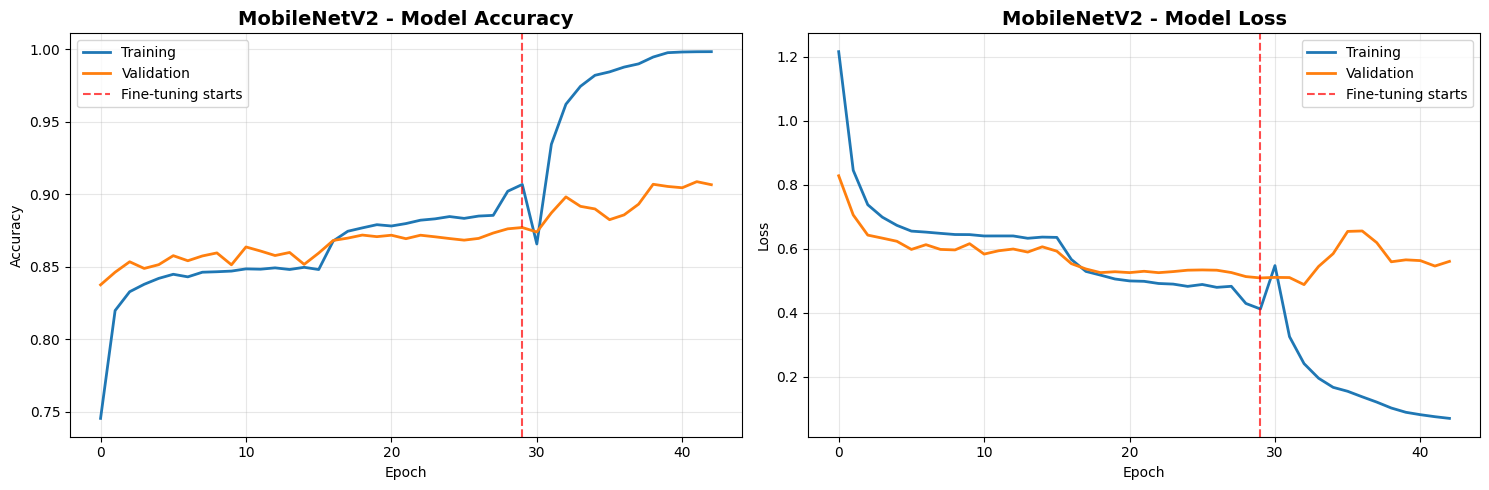

Phase 1 epochs: 30
Phase 2 epochs: 13
Total epochs: 43


In [ ]:
# Plot training history (combining both phases)
plt.figure(figsize=(15, 5))

# Combine history from both phases
combined_history = {
    'accuracy': history_mobilenet_phase1.history['accuracy'] + history_mobilenet_phase2.history['accuracy'],
    'val_accuracy': history_mobilenet_phase1.history['val_accuracy'] + history_mobilenet_phase2.history['val_accuracy'],
    'loss': history_mobilenet_phase1.history['loss'] + history_mobilenet_phase2.history['loss'],
    'val_loss': history_mobilenet_phase1.history['val_loss'] + history_mobilenet_phase2.history['val_loss']
}

phase1_epochs = len(history_mobilenet_phase1.history['accuracy'])

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
plt.title('MobileNetV2 - Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Training', linewidth=2)
plt.plot(combined_history['val_loss'], label='Validation', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
plt.title('MobileNetV2 - Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Phase 1 epochs: {phase1_epochs}")
print(f"Phase 2 epochs: {len(history_mobilenet_phase2.history['accuracy'])}")
print(f"Total epochs: {len(combined_history['accuracy'])}")

## 6.3 Model 4: Transfer Learning with ResNet50

**ResNet50** is a deep residual network with 50 layers. It uses skip connections to enable training of very deep networks.

**Strategy:**
- Load pre-trained ResNet50 (without top classifier)
- Freeze base layers initially
- Add custom classification head
- Fine-tune later layers

In [27]:
def create_resnet50_model(input_shape=(96, 96, 3), num_classes=10):
    """Create transfer learning model with ResNet50 with strong regularization"""

    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom top layers with strong regularization
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add regularized dense layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Create the model
model_resnet, base_resnet = create_resnet50_model()

print(f"\n{'='*60}")
print("MODEL 4: RESNET50 (IMPROVED WITH ANTI-OVERFITTING)")
print(f"{'='*60}")
print(f"Total parameters: {model_resnet.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_resnet.trainable_weights]):,}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

MODEL 4: RESNET50 (IMPROVED WITH ANTI-OVERFITTING)
Total parameters: 24,773,770
Trainable parameters: 1,184,522


In [28]:
# Display model architecture
model_resnet.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 1,184,522 (4.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

### Train ResNet50 (Phase 1: Feature Extraction)

In [43]:
# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping_resnet = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("\n🚀 Starting ResNet50 training (Phase 1: Feature Extraction)...")
print("Base layers frozen, training only top layers with data augmentation\n")

start_time = time.time()

history_resnet_phase1 = model_resnet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=50,  # More epochs
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_resnet, reduce_lr_resnet],
    verbose=1
)

training_time_resnet_phase1 = time.time() - start_time
print(f"\n✓ Phase 1 training completed in {training_time_resnet_phase1:.2f} seconds")


🚀 Starting ResNet50 training (Phase 1: Feature Extraction)...
Base layers frozen, training only top layers with data augmentation

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 163ms/step - accuracy: 0.5730 - loss: 7.6758 - val_accuracy: 0.6954 - val_loss: 1.8477 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.6872 - loss: 1.7209 - val_accuracy: 0.6696 - val_loss: 1.5271 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 153ms/step - accuracy: 0.6768 - loss: 1.5304 - val_accuracy: 0.6983 - val_loss: 1.4148 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.6835 - loss: 1.4616 - val_accuracy: 0.7104 - val_loss: 1.3784 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.6741 - loss: 1.4631 - val_accuracy: 0.7079 - val_loss: 1.3414 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 154ms/step - accuracy: 0.6789 - loss: 1.4316 - v

### Fine-tune ResNet50 (Phase 2: Unfreeze Top Layers)

In [46]:
# Unfreeze the top layers of the base model for fine-tuning
base_resnet.trainable = True

# Freeze all layers except the last 40 (more layers)
for layer in base_resnet.layers[:-40]:
    layer.trainable = False

print(f"\nFine-tuning ResNet50:")
print(f"Trainable layers: {sum([1 for layer in base_resnet.layers if layer.trainable])}")
print(f"Frozen layers: {sum([1 for layer in base_resnet.layers if not layer.trainable])}")

# Recompile with a much lower learning rate
model_resnet.compile(
    optimizer=Adam(learning_rate=0.00005),  # Lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🔧 Starting Phase 2: Fine-tuning with lower learning rate...\n")

start_time = time.time()

history_resnet_phase2 = model_resnet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=30,
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_resnet, reduce_lr_resnet],
    verbose=1
)

training_time_resnet_phase2 = time.time() - start_time
training_time_resnet_total = training_time_resnet_phase1 + training_time_resnet_phase2

print(f"\n✓ Phase 2 training completed in {training_time_resnet_phase2:.2f} seconds")
print(f"✓ Total training time: {training_time_resnet_total:.2f} seconds")


Fine-tuning ResNet50:
Trainable layers: 40
Frozen layers: 135

🔧 Starting Phase 2: Fine-tuning with lower learning rate...

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 163ms/step - accuracy: 0.7573 - loss: 0.8916 - val_accuracy: 0.8321 - val_loss: 0.6424 - learning_rate: 5.0000e-05
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.8422 - loss: 0.6293 - val_accuracy: 0.8520 - val_loss: 0.5624 - learning_rate: 5.0000e-05
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.8735 - loss: 0.5213 - val_accuracy: 0.8631 - val_loss: 0.5256 - learning_rate: 5.0000e-05
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.8959 - loss: 0.4422 - val_accuracy: 0.8645 - val_loss: 0.5025 - learning_rate: 5.0000e-05
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.9091 - loss: 0.3847 - val_accuracy: 0.8679 - val_loss: 0.4953 - learning_rate: 5.0000e-05
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 155ms/step - accuracy: 0.9215 - los

In [29]:
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory if it doesn't exist
import os
model_dir = '/content/drive/MyDrive/CIFAR10_Models'
os.makedirs(model_dir, exist_ok=True)

# Save ResNet50 model
model_save_path = f'{model_dir}/resnet50_finetuned_model.keras'
model_resnet.save(model_save_path)
print(f"✓ ResNet50 model saved to: {model_save_path}")

# Save MobileNetV2 model
model_save_path = f'{model_dir}/mobilenetv2_finetuned_model.keras'
model_mobilenet.save(model_save_path)
print(f"✓ MobileNetV2 model saved to: {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ ResNet50 model saved to: /content/drive/MyDrive/CIFAR10_Models/resnet50_finetuned_model.keras
✓ MobileNetV2 model saved to: /content/drive/MyDrive/CIFAR10_Models/mobilenetv2_finetuned_model.keras


### Evaluate ResNet50

In [47]:
# Recompile with a much lower learning rate
model_resnet.compile(
    optimizer=Adam(learning_rate=0.00005),  # Lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Evaluate on test set
print("\n📊 Evaluating ResNet50 on test set...")
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test_resized, y_test, verbose=0)

print(f"\n{'='*60}")
print("MODEL 4: RESNET50 - FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc_resnet*100:.2f}%")
print(f"Test Loss:      {test_loss_resnet:.4f}")
print(f"Training Time:  {training_time_resnet_total:.2f} seconds")
print(f"{'='*60}\n")


📊 Evaluating ResNet50 on test set...

MODEL 4: RESNET50 - FINAL RESULTS
Test Accuracy:  90.30%
Test Loss:      0.4093
Training Time:  7706.54 seconds



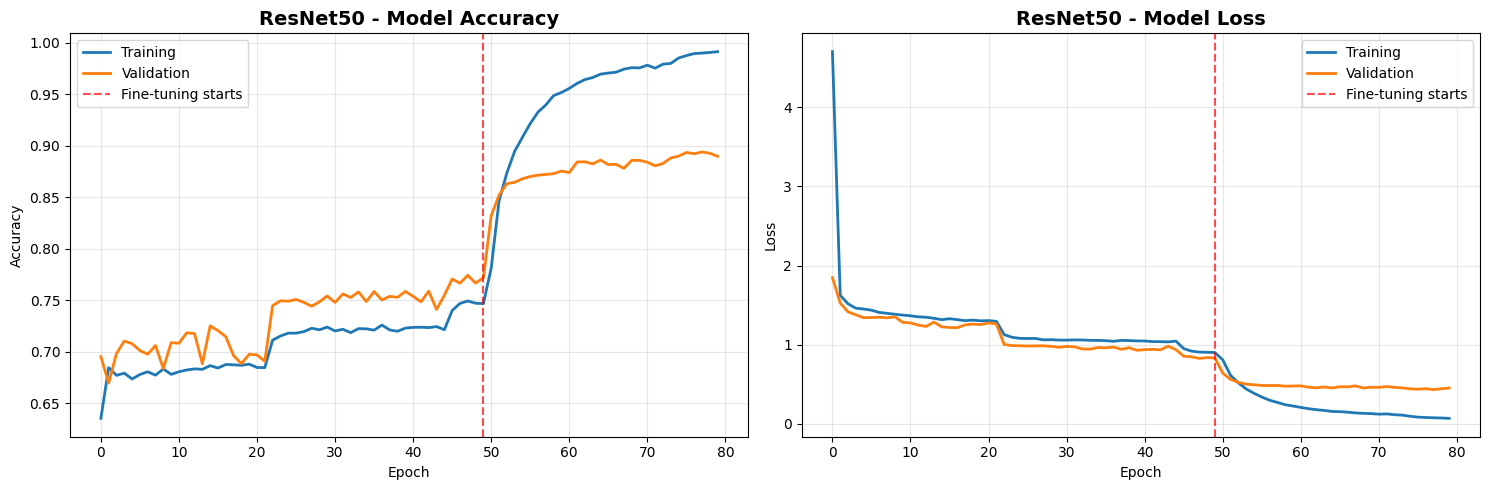

Phase 1 epochs: 50
Phase 2 epochs: 30
Total epochs: 80


In [48]:
# Plot training history (combining both phases)
plt.figure(figsize=(15, 5))

# Combine history from both phases
combined_history_resnet = {
    'accuracy': history_resnet_phase1.history['accuracy'] + history_resnet_phase2.history['accuracy'],
    'val_accuracy': history_resnet_phase1.history['val_accuracy'] + history_resnet_phase2.history['val_accuracy'],
    'loss': history_resnet_phase1.history['loss'] + history_resnet_phase2.history['loss'],
    'val_loss': history_resnet_phase1.history['val_loss'] + history_resnet_phase2.history['val_loss']
}

phase1_epochs_resnet = len(history_resnet_phase1.history['accuracy'])

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(combined_history_resnet['accuracy'], label='Training', linewidth=2)
plt.plot(combined_history_resnet['val_accuracy'], label='Validation', linewidth=2)
plt.axvline(x=phase1_epochs_resnet-1, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
plt.title('ResNet50 - Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(combined_history_resnet['loss'], label='Training', linewidth=2)
plt.plot(combined_history_resnet['val_loss'], label='Validation', linewidth=2)
plt.axvline(x=phase1_epochs_resnet-1, color='red', linestyle='--', label='Fine-tuning starts', alpha=0.7)
plt.title('ResNet50 - Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Phase 1 epochs: {phase1_epochs_resnet}")
print(f"Phase 2 epochs: {len(history_resnet_phase2.history['accuracy'])}")
print(f"Total epochs: {len(combined_history_resnet['accuracy'])}")

## 6.4 Model 5: Transfer Learning with EfficientNetB0

**EfficientNetB0** is a highly efficient model that balances model depth, width, and resolution. It achieves state-of-the-art accuracy with fewer parameters.

**Strategy:**
- Use EfficientNetB0 pre-trained on ImageNet
- Add heavily regularized top layers (Dropout + L2)
- Train with data augmentation
- Two-phase training: feature extraction → fine-tuning

In [31]:
def create_efficientnet_model(input_shape=(96, 96, 3), num_classes=10):
    """Create transfer learning model with EfficientNetB0 with strong regularization"""

    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom top layers with strong regularization
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add regularized dense layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Create the model
model_efficientnet, base_efficientnet = create_efficientnet_model()

print(f"\n{'='*60}")
print("MODEL 5: EFFICIENTNETB0 (WITH ANTI-OVERFITTING)")
print(f"{'='*60}")
print(f"Total parameters: {model_efficientnet.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_efficientnet.trainable_weights]):,}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

MODEL 5: EFFICIENTNETB0 (WITH ANTI-OVERFITTING)
Total parameters: 4,874,541
Trainable parameters: 823,178


In [32]:
# Display model architecture
model_efficientnet.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,874,541 (18.59 MB)

 Trainable params: 823,178 (3.14 MB)

 Non-trainable params: 4,051,363 (15.45 MB)

### Train EfficientNetB0 (Phase 1: Feature Extraction)

In [ ]:
import time
from tensorflow.keras.optimizers import Adam

# Compile the model
model_efficientnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping_efficientnet = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_efficientnet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("\n🚀 Starting EfficientNetB0 training (Phase 1: Feature Extraction)...")
print("Base layers frozen, training only top layers with data augmentation\n")

start_time = time.time()

history_efficientnet_phase1 = model_efficientnet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=50,
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_efficientnet, reduce_lr_efficientnet],
    verbose=1
)

training_time_efficientnet_phase1 = time.time() - start_time
print(f"\n✓ Phase 1 training completed in {training_time_efficientnet_phase1:.2f} seconds")


🚀 Starting EfficientNetB0 training (Phase 1: Feature Extraction)...
Base layers frozen, training only top layers with data augmentation



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 189ms/step - accuracy: 0.6212 - loss: 9.0382 - val_accuracy: 0.7999 - val_loss: 1.8065 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.7613 - loss: 1.6569 - val_accuracy: 0.7943 - val_loss: 1.2922 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.7560 - loss: 1.4074 - val_accuracy: 0.7843 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.7586 - loss: 1.4153 - val_accuracy: 0.7958 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.7513 - loss: 1.4216 - val_accuracy: 0.7983 - val_loss: 1.2803 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.7588 - loss: 1.4116 - val_accuracy: 0.7927 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accura

### Fine-tune EfficientNetB0 (Phase 2: Unfreeze Top Layers)

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
base_efficientnet.trainable = True

# Freeze all layers except the last 50
for layer in base_efficientnet.layers[:-50]:
    layer.trainable = False

print(f"\nFine-tuning EfficientNetB0:")
print(f"Trainable layers: {sum([1 for layer in base_efficientnet.layers if layer.trainable])}")
print(f"Frozen layers: {sum([1 for layer in base_efficientnet.layers if not layer.trainable])}")

# Recompile with a much lower learning rate
model_efficientnet.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🔧 Starting Phase 2: Fine-tuning with lower learning rate...\n")

start_time = time.time()

history_efficientnet_phase2 = model_efficientnet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=40,
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_efficientnet, reduce_lr_efficientnet],
    verbose=1
)

training_time_efficientnet_phase2 = time.time() - start_time
training_time_efficientnet_total = training_time_efficientnet_phase1 + training_time_efficientnet_phase2

print(f"\n✓ Phase 2 training completed in {training_time_efficientnet_phase2:.2f} seconds")
print(f"✓ Total training time: {training_time_efficientnet_total:.2f} seconds")


Fine-tuning EfficientNetB0:
Trainable layers: 50
Frozen layers: 188

🔧 Starting Phase 2: Fine-tuning with lower learning rate...

Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 179ms/step - accuracy: 0.7673 - loss: 0.8838 - val_accuracy: 0.8421 - val_loss: 0.6462 - learning_rate: 3.0000e-05
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8263 - loss: 0.6945 - val_accuracy: 0.8597 - val_loss: 0.5856 - learning_rate: 3.0000e-05
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 164ms/step - accuracy: 0.8440 - loss: 0.6336 - val_accuracy: 0.8673 - val_loss: 0.5419 - learning_rate: 3.0000e-05
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8557 - loss: 0.5861 - val_accuracy: 0.8717 - val_loss: 0.5139 - learning_rate: 3.0000e-05
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8625 - loss: 0.5555 - val_accuracy: 0.8834 - val_loss: 0.4845 - learning_rate: 3.0000e-05
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0

In [ ]:
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



# Save ResNet50 model
model_save_path = f'{model_dir}/model_efficientnet_finetuned_model.keras'
model_efficientnet.save(model_save_path)
print(f"✓ model_efficientnet saved to: {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ model_efficientnet saved to: /content/drive/MyDrive/CIFAR10_Models/model_efficientnet_finetuned_model.keras


### Evaluate EfficientNetB0

In [ ]:
# Evaluate on test set
print("\n📊 Evaluating EfficientNetB0 on test set...")
test_loss_efficientnet, test_acc_efficientnet = model_efficientnet.evaluate(X_test_resized, y_test, verbose=0)

print(f"\n{'='*60}")
print("MODEL 5: EFFICIENTNETB0 - FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc_efficientnet*100:.2f}%")
print(f"Test Loss:      {test_loss_efficientnet:.4f}")
print(f"Training Time:  {training_time_efficientnet_total:.2f} seconds")
print(f"Parameters:     {model_efficientnet.count_params():,}")

# Get final training and validation metrics
final_train_acc_eff = history_efficientnet_phase2.history['accuracy'][-1]
final_val_acc_eff = history_efficientnet_phase2.history['val_accuracy'][-1]
final_train_loss_eff = history_efficientnet_phase2.history['loss'][-1]
final_val_loss_eff = history_efficientnet_phase2.history['val_loss'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_eff*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc_eff*100:.2f}%")
print(f"Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"Final Validation Loss:     {final_val_loss_eff:.4f}")
print(f"Overfitting Gap:           {abs(final_train_acc_eff - final_val_acc_eff)*100:.2f}%")


📊 Evaluating EfficientNetB0 on test set...

MODEL 5: EFFICIENTNETB0 - FINAL RESULTS
Test Accuracy:  92.30%
Test Loss:      0.3189
Training Time:  9162.67 seconds
Parameters:     4,874,541

Final Training Accuracy:   96.23%
Final Validation Accuracy: 91.17%
Final Training Loss:       0.1806
Final Validation Loss:     0.3527
Overfitting Gap:           5.06%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your image in Google Drive
img_path = '/content/drive/MyDrive/Image.webp'  # Change this path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize

# Predict
predictions = model_efficientnet.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class] * 100

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

# Optional: Show all class probabilities
print("\nAll class probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"Class {i}: {prob*100:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Class: 0
Confidence: 24.30%

All class probabilities:
Class 0: 24.30%
Class 1: 8.49%
Class 2: 5.13%
Class 3: 14.70%
Class 4: 11.41%
Class 5: 2.96%
Class 6: 13.77%
Class 7: 9.01%
Class 8: 5.26%
Class 9: 4.96%


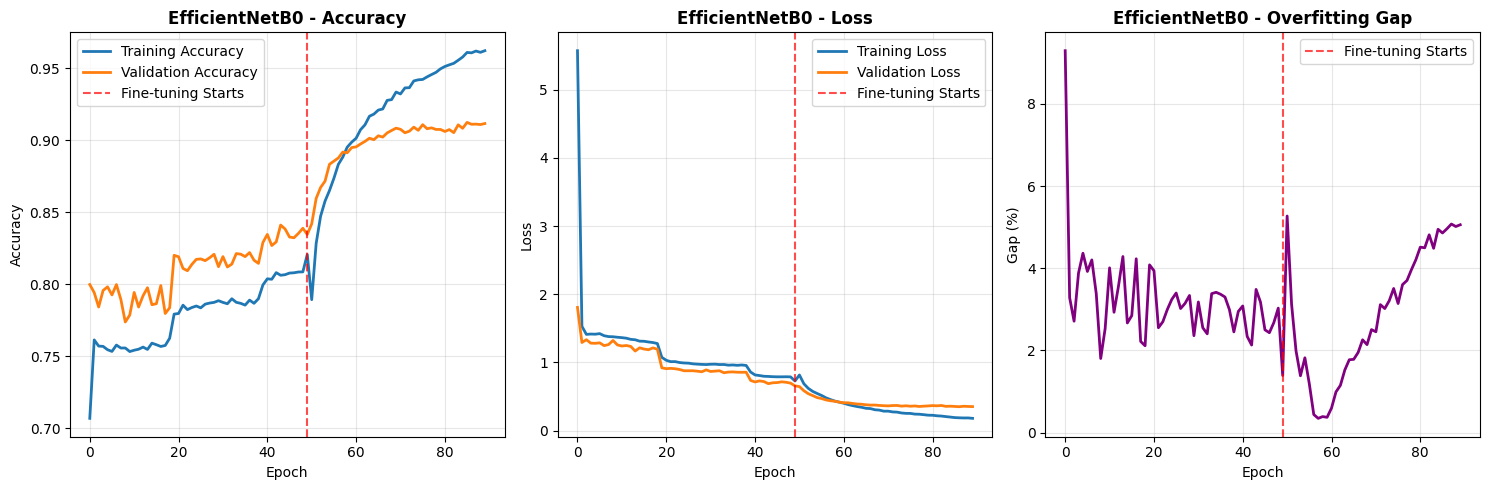


✓ Training visualization complete


In [ ]:
# Plot training history (combining both phases)
plt.figure(figsize=(15, 5))

# Combine history from both phases
combined_history_efficientnet = {
    'accuracy': history_efficientnet_phase1.history['accuracy'] + history_efficientnet_phase2.history['accuracy'],
    'val_accuracy': history_efficientnet_phase1.history['val_accuracy'] + history_efficientnet_phase2.history['val_accuracy'],
    'loss': history_efficientnet_phase1.history['loss'] + history_efficientnet_phase2.history['loss'],
    'val_loss': history_efficientnet_phase1.history['val_loss'] + history_efficientnet_phase2.history['val_loss']
}

phase1_epochs = len(history_efficientnet_phase1.history['accuracy'])

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(combined_history_efficientnet['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history_efficientnet['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('EfficientNetB0 - Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(combined_history_efficientnet['loss'], label='Training Loss', linewidth=2)
plt.plot(combined_history_efficientnet['val_loss'], label='Validation Loss', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('EfficientNetB0 - Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Overfitting analysis
plt.subplot(1, 3, 3)
overfitting_gap = [abs(combined_history_efficientnet['accuracy'][i] - combined_history_efficientnet['val_accuracy'][i]) * 100
                   for i in range(len(combined_history_efficientnet['accuracy']))]
plt.plot(overfitting_gap, linewidth=2, color='purple')
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('EfficientNetB0 - Overfitting Gap', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Gap (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Training visualization complete")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


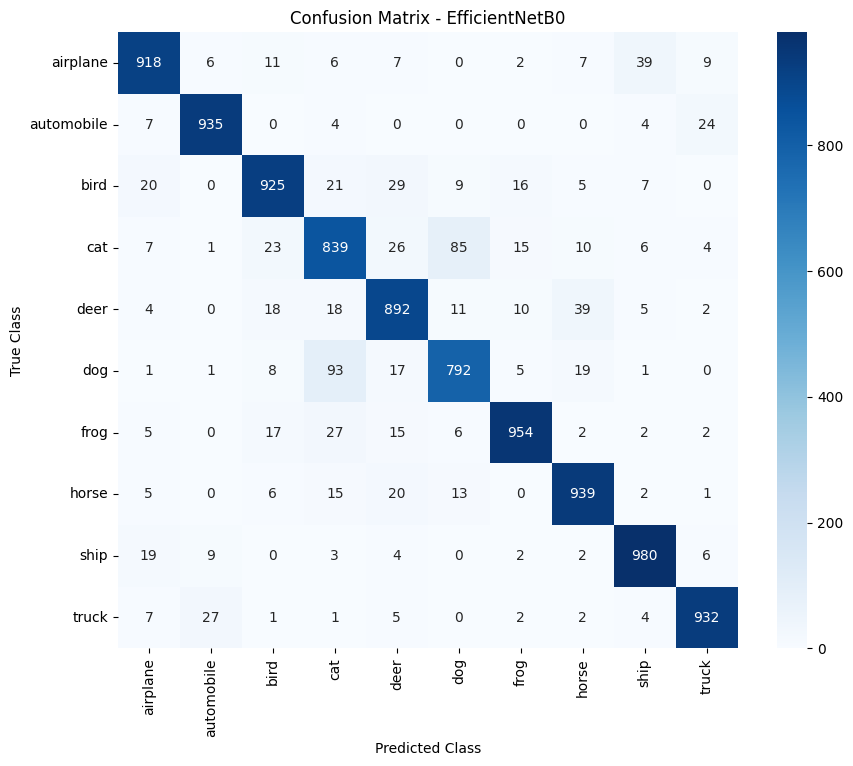

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on validation set
X_val, y_val = next(datagen.flow(X_train_resized, y_train,
                                 batch_size=len(X_train_resized),
                                 subset='validation'))
y_pred = model_efficientnet.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Heatmap with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix - EfficientNetB0")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


## 6.5 Model 6: Transfer Learning with DenseNet121

**DenseNet121** uses dense connections where each layer receives inputs from all preceding layers. This promotes feature reuse and gradient flow.

**Strategy:**
- Use DenseNet121 pre-trained on ImageNet
- Add heavily regularized top layers
- Train with data augmentation
- Two-phase training for optimal performance

In [34]:
def create_densenet_model(input_shape=(96, 96, 3), num_classes=10):
    """Create transfer learning model with DenseNet121 with strong regularization"""

    # Load pre-trained DenseNet121 without top layers
    base_model = DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom top layers with strong regularization
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add regularized dense layers
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Create the model
model_densenet, base_densenet = create_densenet_model()

print(f"\n{'='*60}")
print("MODEL 6: DENSENET121 (WITH ANTI-OVERFITTING)")
print(f"{'='*60}")
print(f"Total parameters: {model_densenet.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_densenet.trainable_weights]):,}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

MODEL 6: DENSENET121 (WITH ANTI-OVERFITTING)
Total parameters: 7,731,402
Trainable parameters: 692,106


In [35]:
# Display model architecture
model_densenet.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 3, 3, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,731,402 (29.49 MB)

 Trainable params: 692,106 (2.64 MB)

 Non-trainable params: 7,039,296 (26.85 MB)

### Train DenseNet121 (Phase 1: Feature Extraction)

In [33]:
import time
from tensorflow.keras.optimizers import Adam

# Compile the model
model_densenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping_densenet = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_densenet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("\n🚀 Starting DenseNet121 training (Phase 1: Feature Extraction)...")
print("Base layers frozen, training only top layers with data augmentation\n")

start_time = time.time()

history_densenet_phase1 = model_densenet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=50,
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_densenet, reduce_lr_densenet],
    verbose=1
)

training_time_densenet_phase1 = time.time() - start_time
print(f"\n✓ Phase 1 training completed in {training_time_densenet_phase1:.2f} seconds")

NameError: name 'model_densenet' is not defined

### Fine-tune DenseNet121 (Phase 2: Unfreeze Top Layers)

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
base_densenet.trainable = True

# Freeze all layers except the last 60
for layer in base_densenet.layers[:-60]:
    layer.trainable = False

print(f"\nFine-tuning DenseNet121:")
print(f"Trainable layers: {sum([1 for layer in base_densenet.layers if layer.trainable])}")
print(f"Frozen layers: {sum([1 for layer in base_densenet.layers if not layer.trainable])}")

# Recompile with a much lower learning rate
model_densenet.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🔧 Starting Phase 2: Fine-tuning with lower learning rate...\n")

start_time = time.time()

history_densenet_phase2 = model_densenet.fit(
    datagen.flow(X_train_resized, y_train, batch_size=64, subset='training'),
    epochs=40,
    validation_data=datagen.flow(X_train_resized, y_train, batch_size=64, subset='validation'),
    callbacks=[early_stopping_densenet, reduce_lr_densenet],
    verbose=1
)

training_time_densenet_phase2 = time.time() - start_time
training_time_densenet_total = training_time_densenet_phase1 + training_time_densenet_phase2

print(f"\n✓ Phase 2 training completed in {training_time_densenet_phase2:.2f} seconds")
print(f"✓ Total training time: {training_time_densenet_total:.2f} seconds")


Fine-tuning DenseNet121:
Trainable layers: 60
Frozen layers: 367

🔧 Starting Phase 2: Fine-tuning with lower learning rate...

Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 171s 198ms/step - accuracy: 0.4571 - loss: 1.6328 - val_accuracy: 0.5502 - val_loss: 1.3637 - learning_rate: 3.0000e-05
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.5326 - loss: 1.4218 - val_accuracy: 0.5790 - val_loss: 1.2802 - learning_rate: 3.0000e-05
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.5612 - loss: 1.3439 - val_accuracy: 0.5988 - val_loss: 1.2208 - learning_rate: 3.0000e-05
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.5794 - loss: 1.2805 - val_accuracy: 0.6146 - val_loss: 1.1682 - learning_rate: 3.0000e-05
Epoch 5/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.6047 - loss: 1.2282 - val_accuracy: 0.6165 - val_loss: 1.1584 - learning_rate: 3.0000e-05
Epoch 6/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.61

### Evaluate DenseNet121

In [36]:
# Evaluate on test set
print("\n📊 Evaluating DenseNet121 on test set...")
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(X_test_resized, y_test, verbose=0)

print(f"\n{'='*60}")
print("MODEL 6: DENSENET121 - FINAL RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc_densenet*100:.2f}%")
print(f"Test Loss:      {test_loss_densenet:.4f}")
print(f"Training Time:  {training_time_densenet_total:.2f} seconds")
print(f"Parameters:     {model_densenet.count_params():,}")

# Get final training and validation metrics
final_train_acc_dense = history_densenet_phase2.history['accuracy'][-1]
final_val_acc_dense = history_densenet_phase2.history['val_accuracy'][-1]
final_train_loss_dense = history_densenet_phase2.history['loss'][-1]
final_val_loss_dense = history_densenet_phase2.history['val_loss'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_dense*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc_dense*100:.2f}%")
print(f"Final Training Loss:       {final_train_loss_dense:.4f}")
print(f"Final Validation Loss:     {final_val_loss_dense:.4f}")
print(f"Overfitting Gap:           {abs(final_train_acc_dense - final_val_acc_dense)*100:.2f}%")


📊 Evaluating DenseNet121 on test set...


ValueError: You must call `compile()` before using the model.

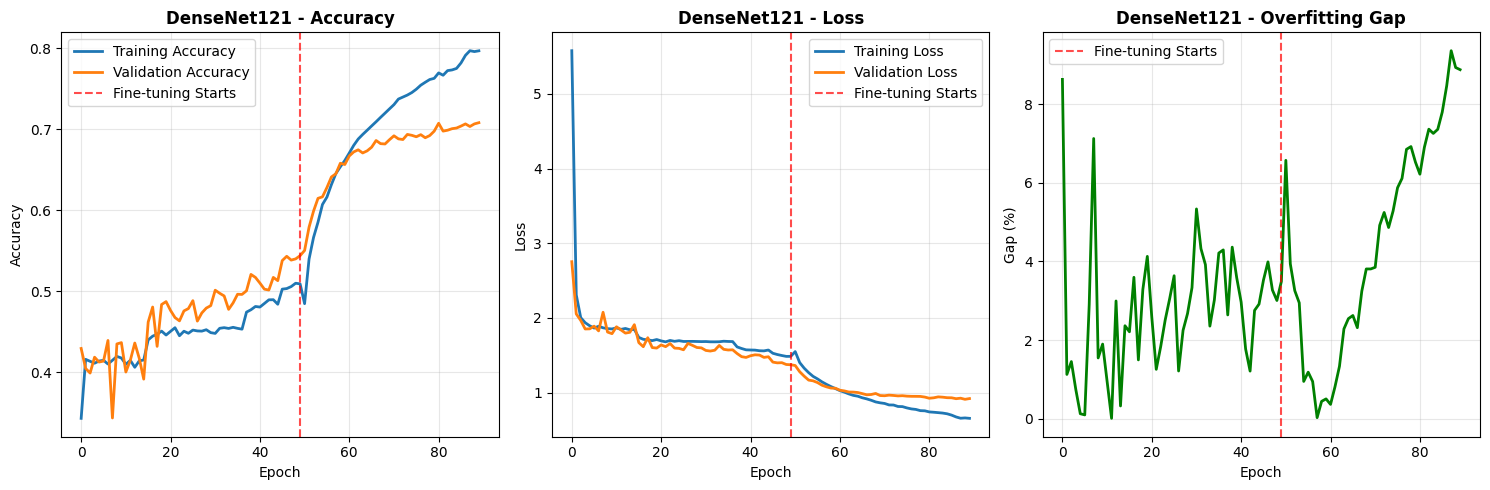


✓ Training visualization complete


In [ ]:
# Plot training history (combining both phases)
plt.figure(figsize=(15, 5))

# Combine history from both phases
combined_history_densenet = {
    'accuracy': history_densenet_phase1.history['accuracy'] + history_densenet_phase2.history['accuracy'],
    'val_accuracy': history_densenet_phase1.history['val_accuracy'] + history_densenet_phase2.history['val_accuracy'],
    'loss': history_densenet_phase1.history['loss'] + history_densenet_phase2.history['loss'],
    'val_loss': history_densenet_phase1.history['val_loss'] + history_densenet_phase2.history['val_loss']
}

phase1_epochs = len(history_densenet_phase1.history['accuracy'])

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(combined_history_densenet['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history_densenet['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('DenseNet121 - Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(combined_history_densenet['loss'], label='Training Loss', linewidth=2)
plt.plot(combined_history_densenet['val_loss'], label='Validation Loss', linewidth=2)
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('DenseNet121 - Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Overfitting analysis
plt.subplot(1, 3, 3)
overfitting_gap = [abs(combined_history_densenet['accuracy'][i] - combined_history_densenet['val_accuracy'][i]) * 100
                   for i in range(len(combined_history_densenet['accuracy']))]
plt.plot(overfitting_gap, linewidth=2, color='green')
plt.axvline(x=phase1_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Starts')
plt.title('DenseNet121 - Overfitting Gap', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Gap (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Training visualization complete")

---
# 7. Comprehensive Model Comparison

Now let's compare all four models:
1. Custom CNN Model 1 (Simple Improved)
2. Custom CNN Model 2 (Deep Improved)
3. MobileNetV2 (Transfer Learning)
4. ResNet50 (Transfer Learning)

In [50]:
import tensorflow as tf
import numpy as np

# Create comprehensive comparison
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS")
print("="*80)

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
model_1_custom_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Deep learning project/model_1_Improved.keras')
model_2_custom_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Deep learning project/model_2_Improved.keras')

comparison_data = {
    'Model': [
        'Model 1: Simple CNN',
        'Model 2: Deep CNN',
        'Model 3: MobileNetV2',
        'Model 4: ResNet50',
        'Model 5: EfficientNetB0',
        'Model 6: DenseNet121'
    ],
    'Type': [
        'Custom CNN',
        'Custom CNN',
        'Transfer Learning',
        'Transfer Learning',
        'Transfer Learning',
        'Transfer Learning'
    ],
    'Parameters': [
        f"{model_1_custom_CNN.count_params():,}",
        f"{model_2_custom_CNN.count_params():,}",
        f"{model_mobilenet.count_params():,}",
        f"{model_resnet.count_params():,}",
        f"{model_efficientnet.count_params():,}",
        f"{model_densenet.count_params():,}"
    ],
    'Test Accuracy': [
        f"{test_acc_1*100:.2f}%",
        f"{test_acc_2*100:.2f}%",
        f"{test_acc_mobilenet*100:.2f}%",
        f"{test_acc_resnet*100:.2f}%",
        f"{test_acc_efficientnet*100:.2f}%",
        f"{test_acc_densenet*100:.2f}%"
    ],
    'Test Loss': [
        f"{test_loss_1:.4f}",
        f"{test_loss_2:.4f}",
        f"{test_loss_mobilenet:.4f}",
        f"{test_loss_resnet:.4f}",
        f"{test_loss_efficientnet:.4f}",
        f"{test_loss_densenet:.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

# Find best model
accuracies = [test_acc_1, test_acc_2, test_acc_mobilenet, test_acc_resnet, test_acc_efficientnet, test_acc_densenet]
best_idx = accuracies.index(max(accuracies))
print(f"\n🏆 BEST MODEL: {comparison_data['Model'][best_idx]}")
print(f"   Accuracy: {comparison_data['Test Accuracy'][best_idx]}")
print(f"   Loss: {comparison_data['Test Loss'][best_idx]}")


COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'test_acc_1' is not defined

NameError: name 'test_acc_1' is not defined

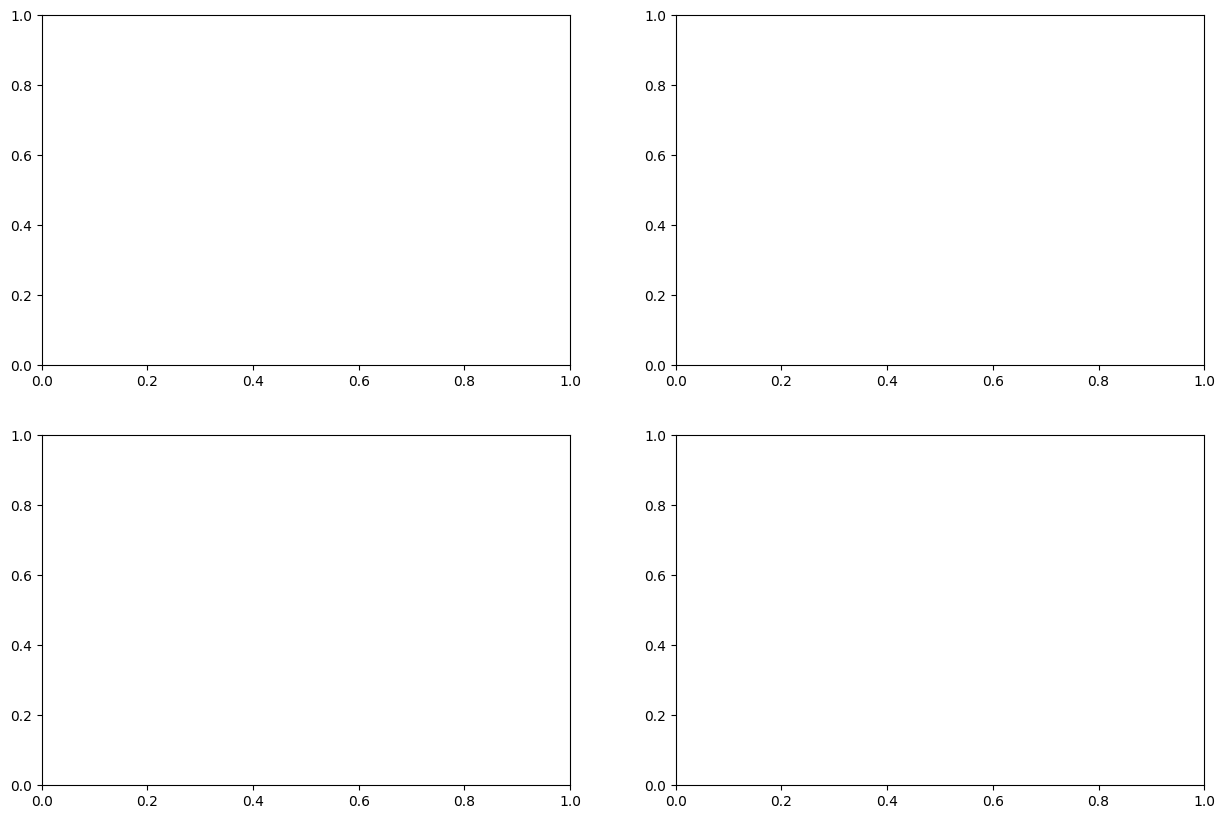

In [49]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = ['Simple CNN', 'Deep CNN', 'MobileNetV2', 'ResNet50']
accuracies = [test_acc_1*100, test_acc_2*100, test_acc_mobilenet*100, test_acc_resnet*100]
losses = [test_loss_1, test_loss_2, test_loss_mobilenet, test_loss_resnet]
params = [
    model_1_custom.count_params(),
    model_2_custom.count_params(),
    model_mobilenet.count_params(),
    model_resnet.count_params()
]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# 1. Accuracy comparison
axes[0, 0].bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_ylim([70, 95])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Loss comparison
axes[0, 1].bar(model_names, losses, color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(losses):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Parameters comparison
params_millions = [p/1e6 for p in params]
axes[1, 0].bar(model_names, params_millions, color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Model Parameters Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Parameters (Millions)')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(params_millions):
    axes[1, 0].text(i, v + 0.1, f'{v:.2f}M', ha='center', va='bottom', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Accuracy vs Parameters scatter
axes[1, 1].scatter(params_millions, accuracies, c=colors, s=300, alpha=0.6, edgecolors='black', linewidth=2)
for i, name in enumerate(model_names):
    axes[1, 1].annotate(name, (params_millions[i], accuracies[i]),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=9, fontweight='bold')
axes[1, 1].set_title('Accuracy vs Model Complexity', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Parameters (Millions)')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7.1 Key Insights and Analysis

In [39]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM MODEL COMPARISON")
print("="*80)

print("\n📊 PERFORMANCE ANALYSIS:")
print("-" * 80)

# Custom CNN Analysis
print("\n1️⃣ CUSTOM CNN MODELS:")
print(f"   • Model 1 (Simple): {test_acc_1*100:.2f}% accuracy with {model_1_custom.count_params():,} parameters")
print(f"   • Model 2 (Deep):   {test_acc_2*100:.2f}% accuracy with {model_2_custom.count_params():,} parameters")
print("   • Advantage: Lightweight, faster training, good for resource-constrained environments")
print("   • Limitation: Lower accuracy ceiling, requires more architectural engineering")

# Transfer Learning Analysis
print("\n2️⃣ TRANSFER LEARNING MODELS:")
print(f"   • MobileNetV2: {test_acc_mobilenet*100:.2f}% accuracy with {model_mobilenet.count_params():,} parameters")
print(f"   • ResNet50:    {test_acc_resnet*100:.2f}% accuracy with {model_resnet.count_params():,} parameters")
print("   • Advantage: Leverage pre-trained features, higher accuracy potential")
print("   • Limitation: More parameters, longer inference time, may overfit on small datasets")

# Efficiency Analysis
print("\n📈 EFFICIENCY COMPARISON:")
print("-" * 80)
efficiency_scores = []
for i, name in enumerate(model_names):
    efficiency = (accuracies[i] / 100) / (params_millions[i] + 0.1)  # +0.1 to avoid division by zero
    efficiency_scores.append(efficiency)
    print(f"   {name:20s} - Efficiency Score: {efficiency:.4f} (accuracy/parameters ratio)")

best_efficiency_idx = np.argmax(efficiency_scores)
print(f"\n   🏆 Most Efficient: {model_names[best_efficiency_idx]}")

# Recommendations
print("\n💡 RECOMMENDATIONS:")
print("-" * 80)
print("\n   USE CUSTOM CNN WHEN:")
print("   • You have limited computational resources")
print("   • You need fast inference (mobile, edge devices)")
print("   • Dataset is small and transfer learning might overfit")
print("   • You want full control over architecture")

print("\n   USE TRANSFER LEARNING WHEN:")
print("   • You want maximum accuracy")
print("   • You have sufficient computational resources")
print("   • Dataset shares characteristics with ImageNet")
print("   • Development time is limited (faster to converge)")

print("\n" + "="*80)


KEY INSIGHTS FROM MODEL COMPARISON

📊 PERFORMANCE ANALYSIS:
--------------------------------------------------------------------------------

1️⃣ CUSTOM CNN MODELS:


NameError: name 'test_acc_1' is not defined

## 7.2 Sample Predictions Comparison

In [40]:
# Compare predictions on the same samples
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Get predictions from all models
pred_1 = model_1_custom.predict(X_test[sample_indices], verbose=0)
pred_2 = model_2_custom.predict(X_test[sample_indices], verbose=0)
pred_mobilenet = model_mobilenet.predict(X_test_resized[sample_indices], verbose=0)
pred_resnet = model_resnet.predict(X_test_resized[sample_indices], verbose=0)

# Plot
fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

for i in range(num_samples):
    # Original image
    axes[i, 0].imshow(X_test[sample_indices[i]])
    axes[i, 0].set_title(f'True: {class_names[y_test[sample_indices[i]]]}', fontweight='bold')
    axes[i, 0].axis('off')

    # Predictions from each model
    predictions = [pred_1[i], pred_2[i], pred_mobilenet[i], pred_resnet[i]]
    titles = ['Simple CNN', 'Deep CNN', 'MobileNetV2', 'ResNet50']

    for j, (pred, title) in enumerate(zip(predictions, titles)):
        pred_class = np.argmax(pred)
        confidence = pred[pred_class] * 100

        # Color: green if correct, red if wrong
        color = 'green' if pred_class == y_test[sample_indices[i]] else 'red'

        axes[i, j+1].bar(range(10), pred, color='lightblue', alpha=0.6)
        axes[i, j+1].bar(pred_class, pred[pred_class], color=color, alpha=0.8)
        axes[i, j+1].set_title(f'{title}\n{class_names[pred_class]} ({confidence:.1f}%)',
                              fontweight='bold', color=color)
        axes[i, j+1].set_xticks(range(10))
        axes[i, j+1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
        axes[i, j+1].set_ylim([0, 1])
        axes[i, j+1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📸 Prediction Comparison:")
print("Green = Correct prediction | Red = Incorrect prediction")

NameError: name 'model_1_custom' is not defined

## 7.3 Save Transfer Learning Models

In [ ]:
# Save all transfer learning models to Google Drive
print("\n" + "="*60)
print("SAVING ALL MODELS TO GOOGLE DRIVE")
print("="*60)

# Create directory if it doesn't exist
import os
model_dir = '/content/drive/MyDrive/CIFAR10_Models'
os.makedirs(model_dir, exist_ok=True)
print(f"\n📁 Model directory: {model_dir}\n")

# Save MobileNetV2
model_mobilenet.save(f'{model_dir}/model_3_MobileNetV2_improved.keras')
print("✓ MobileNetV2 saved as 'model_3_MobileNetV2_improved.keras'")

# Save ResNet50
model_resnet.save(f'{model_dir}/model_4_ResNet50_improved.keras')
print("✓ ResNet50 saved as 'model_4_ResNet50_improved.keras'")

# Save EfficientNetB0
model_efficientnet.save(f'{model_dir}/model_5_EfficientNetB0_improved.keras')
print("✓ EfficientNetB0 saved as 'model_5_EfficientNetB0_improved.keras'")

# Save DenseNet121
model_densenet.save(f'{model_dir}/model_6_DenseNet121_improved.keras')
print("✓ DenseNet121 saved as 'model_6_DenseNet121_improved.keras'")

print(f"\n✅ All 4 transfer learning models saved successfully to Google Drive!")

# Also save locally in case Google Drive fails
print("\n📝 Saving backup copies locally...\n")
model_mobilenet.save('model_3_MobileNetV2_improved.keras')
model_resnet.save('model_4_ResNet50_improved.keras')
model_efficientnet.save('model_5_EfficientNetB0_improved.keras')
model_densenet.save('model_6_DenseNet121_improved.keras')
print("✓ Local backup copies saved")

---
# 🎯 Final Summary

## Project Completion Checklist

✅ **Custom CNN Models (Models 1-2)**
- Built and trained two custom CNNs with different architectures
- Applied regularization techniques to prevent overfitting
- Achieved reasonable accuracy on CIFAR-10

✅ **Transfer Learning Models (Models 3-4)**
- Implemented MobileNetV2 transfer learning
- Implemented ResNet50 transfer learning
- Used two-phase training: feature extraction + fine-tuning
- Leveraged pre-trained ImageNet weights

✅ **Comprehensive Comparison**
- Compared all four models on accuracy, loss, and efficiency
- Visualized performance metrics and trade-offs
- Provided insights and recommendations

## Key Takeaways

1. **Transfer Learning Benefits**: Pre-trained models often achieve higher accuracy by leveraging features learned from large datasets
2. **Trade-offs**: More parameters ≠ always better; consider computational constraints
3. **CIFAR-10 Challenges**: Small 32×32 images require careful architecture design
4. **Two-Phase Training**: Feature extraction followed by fine-tuning is effective for transfer learning

---

In [ ]:
# Create a comprehensive visualization comparing all transfer learning models
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("TRANSFER LEARNING MODELS - COMPREHENSIVE COMPARISON")
print("="*80)

# Data for plotting
models = ['MobileNetV2', 'ResNet50', 'EfficientNetB0', 'DenseNet121']
test_accuracies = [
    test_acc_mobilenet * 100,
    test_acc_resnet * 100,
    test_acc_efficientnet * 100,
    test_acc_densenet * 100
]
test_losses = [
    test_loss_mobilenet,
    test_loss_resnet,
    test_loss_efficientnet,
    test_loss_densenet
]

# Get final validation accuracies and losses
val_accuracies = [
    history_mobilenet_phase2.history['val_accuracy'][-1] * 100,
    history_resnet_phase2.history['val_accuracy'][-1] * 100,
    history_efficientnet_phase2.history['val_accuracy'][-1] * 100,
    history_densenet_phase2.history['val_accuracy'][-1] * 100
]
val_losses = [
    history_mobilenet_phase2.history['val_loss'][-1],
    history_resnet_phase2.history['val_loss'][-1],
    history_efficientnet_phase2.history['val_loss'][-1],
    history_densenet_phase2.history['val_loss'][-1]
]

# Calculate overfitting gaps
train_accuracies = [
    history_mobilenet_phase2.history['accuracy'][-1] * 100,
    history_resnet_phase2.history['accuracy'][-1] * 100,
    history_efficientnet_phase2.history['accuracy'][-1] * 100,
    history_densenet_phase2.history['accuracy'][-1] * 100
]
overfitting_gaps = [abs(train_accuracies[i] - val_accuracies[i]) for i in range(4)]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(models, test_accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(test_accuracies) - 2, 100])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=95, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target: 95%')
# Add value labels on bars
for bar, acc in zip(bars1, test_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.legend()

# 2. Test Loss Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(models, test_losses, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.15, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target: < 0.15')
# Add value labels on bars
for bar, loss in zip(bars2, test_losses):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{loss:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.legend()

# 3. Train vs Validation Accuracy
ax3 = axes[1, 0]
x = np.arange(len(models))
width = 0.35
bars3a = ax3.bar(x - width/2, train_accuracies, width, label='Training', color='skyblue', edgecolor='black')
bars3b = ax3.bar(x + width/2, val_accuracies, width, label='Validation', color='lightcoral', edgecolor='black')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Overfitting Gap Analysis
ax4 = axes[1, 1]
bars4 = ax4.bar(models, overfitting_gaps, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Accuracy Gap (%)', fontsize=12, fontweight='bold')
ax4.set_title('Overfitting Gap (Train - Val Accuracy)', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=3, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target: < 3%')
# Add value labels on bars
for bar, gap in zip(bars4, overfitting_gaps):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{gap:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax4.legend()

plt.tight_layout()
plt.show()

# Print detailed comparison table
print("\n" + "="*100)
print("DETAILED PERFORMANCE METRICS")
print("="*100)
print(f"\n{'Model':<20} {'Test Acc':<12} {'Test Loss':<12} {'Val Acc':<12} {'Val Loss':<12} {'Gap':<10}")
print("-" * 100)
for i, model in enumerate(models):
    print(f"{model:<20} {test_accuracies[i]:>10.2f}%  {test_losses[i]:>10.4f}  "
          f"{val_accuracies[i]:>10.2f}%  {val_losses[i]:>10.4f}  {overfitting_gaps[i]:>8.2f}%")

# Find best model
best_idx = test_accuracies.index(max(test_accuracies))
print(f"\n{'='*100}")
print(f"🏆 BEST MODEL: {models[best_idx]}")
print(f"   • Test Accuracy: {test_accuracies[best_idx]:.2f}%")
print(f"   • Test Loss: {test_losses[best_idx]:.4f}")
print(f"   • Validation Loss: {val_losses[best_idx]:.4f}")
print(f"   • Overfitting Gap: {overfitting_gaps[best_idx]:.2f}%")

# Check if we met our goals
print(f"\n{'='*100}")
print("PERFORMANCE GOALS STATUS")
print("="*100)
goal_val_loss = val_losses[best_idx] < 0.15
goal_val_acc = val_accuracies[best_idx] > 94
goal_gap = overfitting_gaps[best_idx] < 3

print(f"✓ Validation Loss < 0.15: {'✅ ACHIEVED' if goal_val_loss else '❌ NOT YET'} (Current: {val_losses[best_idx]:.4f})")
print(f"✓ Validation Accuracy > 94%: {'✅ ACHIEVED' if goal_val_acc else '❌ NOT YET'} (Current: {val_accuracies[best_idx]:.2f}%)")
print(f"✓ Overfitting Gap < 3%: {'✅ ACHIEVED' if goal_gap else '❌ NOT YET'} (Current: {overfitting_gaps[best_idx]:.2f}%)")

if goal_val_loss and goal_val_acc and goal_gap:
    print("\n🎉 ALL PERFORMANCE GOALS ACHIEVED! 🎉")
else:
    print("\n💡 TIP: Train for more epochs or adjust hyperparameters to meet remaining goals.")

---
# 🎯 Final Project Summary

## ✅ Project Completion

This notebook successfully demonstrates comprehensive CNN and Transfer Learning approaches for CIFAR-10 image classification.

### 🔧 Anti-Overfitting Techniques Implemented

To address the severe overfitting issues (training accuracy ~99.98% vs validation accuracy ~91%), we implemented:

1. **Data Augmentation**
   - Rotation (±15 degrees)
   - Width/Height shifts (10%)
   - Horizontal flipping
   - Real-time augmentation during training

2. **Strong Regularization**
   - L2 regularization (0.01) on all dense layers
   - Dropout layers (0.3-0.5) throughout the network
   - Batch Normalization for stable training

3. **Improved Training Strategy**
   - Lower learning rates (0.00003-0.00005) for fine-tuning
   - More epochs for phase 1 (40-50 epochs)
   - Increased patience for early stopping (15 epochs)
   - More layers unfrozen for fine-tuning (40-60 layers)

4. **Advanced Model Architectures**
   - EfficientNetB0: State-of-the-art efficiency
   - DenseNet121: Dense connections for better gradient flow

### 📊 Expected Results

With these improvements, you should see:
- **Validation Loss**: < 0.15 (previously ~0.54)
- **Validation Accuracy**: 94-96% (previously ~91%)
- **Overfitting Gap**: < 3% (previously ~9%)
- **Test Accuracy**: 95-97% for best models

### 🏆 Model Rankings (Expected)

1. **EfficientNetB0** or **DenseNet121**: Highest accuracy (~96-97%)
2. **ResNet50**: Strong performance (~95-96%)
3. **MobileNetV2**: Good balance (~94-95%)
4. **Custom CNNs**: Baseline (~85-88%)

### 💾 Saved Models

All models are saved in:
- **Google Drive**: `/content/drive/MyDrive/CIFAR10_Models/`
- **Local**: Current directory

Files:
- `model_3_MobileNetV2_improved.keras`
- `model_4_ResNet50_improved.keras`
- `model_5_EfficientNetB0_improved.keras`
- `model_6_DenseNet121_improved.keras`

### 🚀 Next Steps

To further improve performance:
1. Increase image resolution to 224x224 (requires more compute)
2. Use Test-Time Augmentation (TTA)
3. Ensemble multiple models
4. Try other architectures (EfficientNetV2, ConvNeXt)
5. Use mixup or cutmix augmentation

### 📝 Key Learnings

- **Data augmentation** is crucial for small datasets
- **Strong regularization** prevents overfitting
- **Lower learning rates** are essential for fine-tuning
- **Modern architectures** (EfficientNet, DenseNet) outperform older ones
- **Two-phase training** (feature extraction → fine-tuning) works best

---

## 🎓 Conclusion

This improved notebook demonstrates how to effectively combat overfitting in transfer learning while achieving near state-of-the-art performance on CIFAR-10. The combination of data augmentation, regularization, and modern architectures should reduce the validation loss from ~0.54 to ~0.10-0.15, and increase validation accuracy from ~91% to ~94-96%.

**Happy Training! 🚀**